In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import localSettings as ls
import math
print(ls.main_path)


/home/amoor/NuMI/NuMI_Analysis/PELEE


In [3]:
main_path = ls.main_path
sys.path.append(main_path)

In [4]:
import NuMIGeoWeights
import importlib
importlib.reload(NuMIGeoWeights)
numiBeamlineGeoWeights = NuMIGeoWeights.NuMIGeoWeights()
#print(numiBeamlineGeoWeights.calculateGeoWeight(14,0.01,5.))

In [5]:
from datetime import datetime
now = datetime.now()
date_time = now.strftime("%m%d%Y")
print("date and time:",date_time)

date and time: 02172021


In [6]:
SHRCALIBFACTOR = 1.00

In [7]:
# USING BDT?
USEBDT = True

In [8]:
# Doing Run3?
ISRUN3 = False

In [9]:
# scale to MCC8 CV?
MCC8WEIGHTS = False

In [10]:
import plotter
import importlib
importlib.reload(plotter)
import uproot
import matplotlib.pylab as pylab
import numpy as np
import math
from sklearn.model_selection import train_test_split
import pickle
import xgboost as xgb
import nue_booster 
importlib.reload(nue_booster)
import awkward

params = {
    'axes.labelsize': 'x-large',
    'axes.titlesize': 'x-large',
    'xtick.labelsize': 'x-large',
    'ytick.labelsize': 'x-large'
}
pylab.rcParams.update(params)

In [11]:
from scipy.spatial.transform import Rotation as R
from numpy import arccos, array
from numpy.linalg import norm

# Note: returns angle in radians
def theta(v, w): return arccos(v.dot(w)/(norm(v)*norm(w)))* 180 / 3.1415926

def GetNuMIAngle( px,  py,  pz):
    r = R.from_matrix([[0.92103853804025681562   , 0.022713504803924120662, 0.38880857519374290021  ],
                       [4.6254001262154668408e-05, 0.99829162468141474651 , -0.058427989452906302359],
                       [-0.38947144863934973769  , 0.053832413938664107345, 0.91946400794392302291  ]])  
    r = r.inv()
    beamCoords = r.apply([px,  py,  pz])
    beamDir    = [0,0,1]
    #print(theta(beamCoords,beamDir))
    return theta(beamCoords,beamDir)

def GetNuMIAnglePol( phiBNB,  thetaBNB):
    px = math.sin(thetaBNB)*math.cos(phiBNB)
    py = math.sin(thetaBNB)*math.sin(phiBNB)
    pz = math.cos(thetaBNB)
    return GetNuMIAngle( px,  py,  pz)


In [12]:
tree = "NeutrinoSelectionFilter"

# original
#BNB  = 'neutrinoselection_filt_run1_beamon_beamgood_all' +ls.APPEND
#EXT  = 'neutrinoselection_filt_run1_beamoff_all'         +ls.APPEND
#NU   = 'newTune/prodgenie_numi_uboone_overlay_fhc_mcc9_run1_v28_all_snapshot'    +ls.APPEND #newTune
#NUE  = 'newTune/prodgenie_numi_nue_overlay_mcc9_v08_00_00_48_CV_reco2_run1_reco2'+ls.APPEND #newTune
#DRT  = 'neutrinoselection_filt_run1_dirt_overlay'        +ls.APPEND
# old tune
#NUO  = 'neutrinoselection_filt_run1_overlay'            +ls.APPEND
#NUEO = 'neutrinoselection_filt_run1_overlay_intrinsic'  +ls.APPEND
#mcO   = uproot.open(ls.ntuple_path+NUO +".root")[ls.fold][tree]
#nueO  = uproot.open(ls.ntuple_path+NUEO+".root")[ls.fold][tree]


#new
BNB  = '/neutrinoselection_filt_run1_beamon_beamgood' +ls.APPEND
EXT  = '/neutrinoselection_filt_run1_beamoff'         +ls.APPEND
NU   = '/prodgenie_numi_uboone_overlay_fhc_mcc9_run1_v28_all_snapshot'    +ls.APPEND #newTune
NUE  = '/prodgenie_numi_nue_overlay_mcc9_v08_00_00_48_CV_reco2_run1_reco2'+ls.APPEND #newTune
DRT  = '/neutrinoselection_filt_run1_dirt_overlay'        +ls.APPEND


mc   = uproot.open(ls.ntuple_path+NU +".root")[ls.fold][tree]
nue  = uproot.open(ls.ntuple_path+NUE+".root")[ls.fold][tree]
data = uproot.open(ls.ntuple_path+BNB+".root")[ls.fold][tree]
ext  = uproot.open(ls.ntuple_path+EXT+".root")[ls.fold][tree]
dirt = uproot.open(ls.ntuple_path+DRT+".root")[ls.fold][tree]


uproot_v = [mc,nue,ext,data,dirt] 

variables = ["run", "sub", "evt", "nu_pdg","shr_tkfit_nhits_Y", "shr_tkfit_nhits_U", "shr_tkfit_nhits_V", "shr_tkfit_dedx_Y", 
             "shr_tkfit_dedx_U", "shr_tkfit_dedx_V", 
             "shr_tkfit_2cm_nhits_Y", "shr_tkfit_2cm_nhits_U", "shr_tkfit_2cm_nhits_V", 
             "shr_tkfit_2cm_dedx_Y", "shr_tkfit_2cm_dedx_U", "shr_tkfit_2cm_dedx_V",             
             "shr_energy_tot_cali", "trk_energy_tot", "shr_energy", "shr_theta", "trk_theta_v", "trk_phi_v", 
             "trk_score_v", "trk_llr_pid_score_v", "topological_score","trk_energy_proton_v", "trk_calo_energy_y_v", "trk_id", 
             "n_tracks_contained", "shrsubclusters0", "shrsubclusters1", "shrsubclusters2", 
             "shr_tkfit_npointsvalid", "shr_tkfit_npoints", "secondshower_Y_dir", "shrclusdir2", "trk_theta", 
             "trk_sce_start_x_v", "trk_sce_start_y_v", "trk_sce_start_z_v", 
             "trk_sce_end_x_v", "trk_sce_end_y_v", "trk_sce_end_z_v", 
             "shrmoliereavg", "secondshower_Y_dot", "true_e_visible",
             "pfnhits", "pfnunhits", "flash_time", "category", "shr_score", "tksh_distance", "tksh_angle",
             "trkshrhitdist2", "hits_ratio", "secondshower_Y_nhit", "secondshower_Y_vtxdist", "CosmicIPAll3D", 
             "CosmicDirAll3D", "nslice", "selected", "_opfilter_pe_beam", "_opfilter_pe_veto", "n_showers_contained", 
             "reco_nu_vtx_sce_x", "reco_nu_vtx_sce_y", "reco_nu_vtx_sce_z", 
             "pt", "shr_phi", "shr_tkfit_gap10_nhits_Y","shr_tkfit_gap10_nhits_U","shr_tkfit_gap10_nhits_V",
             "shr_tkfit_gap10_dedx_Y", "shr_tkfit_gap10_dedx_U", "shr_tkfit_gap10_dedx_V",
             "slnunhits","slnhits","pi0_e","ccnc","shr_pz","shr_py","shr_px"]

varMC = ["nu_e","true_pt","true_pt_visible","true_p","true_p_visible","true_nu_vtx_t","true_nu_vtx_x","true_nu_vtx_y","true_nu_vtx_z","true_nu_vtx_sce_x","true_nu_vtx_sce_y","true_nu_vtx_sce_z\
","true_nu_px","true_nu_py","true_nu_pz"]
'''
variables = [
    "shr_dedx_Y", "shr_bkt_pdg", "p", "pt", "selected", "nu_pdg", "shr_theta",
    "slpdg", "trk_score_v", "backtracked_pdg", # modified from shr_score_v
    "shr_pfp_id_v", "category", "flash_time",
    "shr_tkfit_dedx_U","shr_tkfit_dedx_V","shr_tkfit_dedx_Y",
    "shr_tkfit_gap10_dedx_U","shr_tkfit_gap10_dedx_V","shr_tkfit_gap10_dedx_Y",
    "shr_tkfit_2cm_dedx_U","shr_tkfit_2cm_dedx_V","shr_tkfit_2cm_dedx_Y",
    "topological_score",
    #"shr_energy_tot", 
    "trk_energy_tot", "shr_hits_tot", "ccnc", "trk_chipr",
    "trk_bkt_pdg", "hits_ratio", "n_tracks_contained", 
    "crtveto","crthitpe","_closestNuCosmicDist",
    "NeutrinoEnergy2",
    #"run","sub","evt",
    "CosmicIP","CosmicDirAll3D","CosmicIPAll3D",
    "nu_flashmatch_score","best_cosmic_flashmatch_score","best_obviouscosmic_flashmatch_score",
    #"trk_pfp_id",
    "shrmoliereavg","shrmoliererms",
    "shr_tkfit_npointsvalid","shr_tkfit_npoints", # fitted vs. all hits for shower
    "shrclusfrac0","shrclusfrac1","shrclusfrac2", # track-fitted hits / all hits
    "trkshrhitdist2", # "trkshrhitdist0","trkshrhitdist1", distance between track and shower in 2D
    "shrsubclusters0","shrsubclusters1","shrsubclusters2", # number of sub-clusters in shower
    "trk_llr_pid_score_v", # trk-PID score
    "trk_energy_proton_v", # track energy under proton hyp
    "trk_calo_energy_y_v", # track calo energy
    #"pi0_energy2_Y", # pi0 tagger variables
    "_opfilter_pe_beam", "_opfilter_pe_veto", # did the event pass the common optical filter (for MC only)
    "reco_nu_vtx_sce_x","reco_nu_vtx_sce_y","reco_nu_vtx_sce_z",
    "nproton", "nu_e", "n_showers_contained", "shr_distance", "trk_distance",
    "hits_y", "shr_pz", "shr_energy", "shr_dedx_U", "shr_dedx_V", "shr_phi", "trk_phi", "trk_theta",
    "shr_tkfit_dedx_U", "shr_tkfit_dedx_V", 
    "run", "sub", "evt", 
    "nproton", "trk_pid_chipr_v",
    "trk_len", "mc_pdg", "slnunhits", "slnhits", "shr_score", "trk_score", "trk_hits_tot",
    "true_e_visible", "matched_E", "shr_bkt_E", "trk_bkt_E", "trk_energy", "tksh_distance", "tksh_angle",
    "npi0","npion","pion_e","muon_e","pi0truth_elec_etot",
    "pi0_e", "shr_energy_tot_cali", "shr_dedx_Y_cali", "evnunhits", "nslice", "interaction",
    "slclustfrac", "reco_nu_vtx_x", "reco_nu_vtx_y", "reco_nu_vtx_z","contained_fraction",
    "secondshower_Y_nhit","secondshower_Y_vtxdist","secondshower_Y_dot","secondshower_Y_dir","shrclusdir2",
    "shr_tkfit_nhits_Y","shr_tkfit_nhits_U","shr_tkfit_nhits_V",
    "shr_tkfit_2cm_nhits_Y","shr_tkfit_2cm_nhits_U","shr_tkfit_2cm_nhits_V",
    "shr_tkfit_gap10_nhits_Y","shr_tkfit_gap10_nhits_U","shr_tkfit_gap10_nhits_V",
    "pfnhits","pfnunhits",
    "trk_sce_start_x_v","trk_sce_start_y_v","trk_sce_start_z_v",
    "trk_sce_end_x_v","trk_sce_end_y_v","trk_sce_end_z_v","shr_id", 
    "pi0_radlen1","pi0_radlen2","pi0_dot1","pi0_dot2","pi0_energy1_Y","pi0_energy2_Y",
    "pi0_dedx1_fit_Y","pi0_dedx2_fit_Y","pi0_shrscore1","pi0_shrscore2","pi0_gammadot",
    "pi0_dedx1_fit_V","pi0_dedx2_fit_V","pi0_dedx1_fit_U","pi0_dedx2_fit_U",
    "pi0_mass_Y","pi0_mass_V","pi0_mass_U",
    "pi0_dir2_x","pi0_dir2_y","pi0_dir2_z","pi0_dir1_x","pi0_dir1_y","pi0_dir1_z",
    "pi0truth_gamma1_etot","pi0truth_gamma2_etot","pi0truth_gammadot","pi0truth_gamma_parent",
    "trk_theta_v","trk_phi_v"
]
'''

#make the list unique
variables = list(set(variables))
print(variables)


    
WEIGHTS     = ["weightSpline","weightTune","weightSplineTimesTune","ppfx_cv"]
SYSTEMATICS = ['weightsFlux','weightsGenie','weightsReint'] 
PPFX        = ['weightsPPFX'] 



WEIGHTSLEE = ["weightSpline","weightTune","weightSplineTimesTune", "leeweight"]#, "weightsGenie", "weightsFlux", "weightsReint"]
MCFVARS    = ["mcf_nu_e","mcf_lep_e","mcf_actvol","mcf_nmm","mcf_nmp","mcf_nem","mcf_nep","mcf_np0","mcf_npp",
              "mcf_npm","mcf_mcshr_elec_etot","mcf_pass_ccpi0","mcf_pass_ncpi0",
              "mcf_pass_ccnopi","mcf_pass_ncnopi","mcf_pass_cccpi","mcf_pass_nccpi"]


    
dirt = dirt.pandas.df(variables+varMC + WEIGHTS + SYSTEMATICS, flatten=False)
nue  = nue.pandas.df(variables + WEIGHTS + MCFVARS + SYSTEMATICS + PPFX+varMC, flatten=False)
mc   = mc.pandas.df(variables + WEIGHTS + MCFVARS + SYSTEMATICS + PPFX+varMC, flatten=False)
data = data.pandas.df(variables, flatten=False)
ext  = ext.pandas.df(variables, flatten=False)



['trk_llr_pid_score_v', 'n_tracks_contained', 'shr_tkfit_gap10_dedx_Y', 'shr_tkfit_gap10_nhits_V', 'shr_energy', 'slnhits', 'shr_tkfit_2cm_nhits_U', 'pfnunhits', 'shr_phi', 'tksh_angle', 'shrsubclusters2', 'true_e_visible', 'trk_sce_start_z_v', 'shr_tkfit_2cm_nhits_Y', 'shr_tkfit_2cm_dedx_V', 'shrclusdir2', 'reco_nu_vtx_sce_z', 'CosmicIPAll3D', 'sub', 'nu_pdg', 'shr_tkfit_nhits_Y', 'ccnc', 'shr_tkfit_gap10_dedx_V', 'trk_phi_v', 'shr_tkfit_npointsvalid', 'shr_tkfit_dedx_Y', 'shr_pz', 'shr_tkfit_gap10_dedx_U', 'shr_tkfit_nhits_V', 'trk_calo_energy_y_v', 'flash_time', 'n_showers_contained', 'trk_theta_v', 'hits_ratio', 'shr_tkfit_2cm_nhits_V', 'trkshrhitdist2', 'run', 'reco_nu_vtx_sce_y', 'shr_tkfit_2cm_dedx_U', 'shr_energy_tot_cali', 'shr_tkfit_gap10_nhits_Y', 'pi0_e', 'shr_tkfit_npoints', 'shrsubclusters0', 'topological_score', 'shr_tkfit_dedx_V', 'shr_tkfit_gap10_nhits_U', 'tksh_distance', '_opfilter_pe_veto', 'trk_score_v', 'shrsubclusters1', 'shr_px', 'reco_nu_vtx_sce_x', 'shr_tkfit_

In [13]:
df_v = [mc,nue,dirt]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df[ 'currentweightsafe' ] = df['weightSplineTimesTune']
    df[ 'currentweight' ] = df['weightSplineTimesTune']
    

In [14]:
constructNuMISys = True

#df_v = [mc,nue]
#for i,df in enumerate(df_v):#
#    df[ 'weightSplineTimesTuneTimesPPFX' ] = df[ 'weightSplineTimesTune' ]*df['ppfx_cv']

df_v = [mc,nue,dirt]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df.loc[ df['weightTune'] <= 0, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] == np.inf, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] > 100, 'weightTune' ] = 1.
    df.loc[ np.isnan(df['weightTune']) == True, 'weightTune' ] = 1.    
    df.loc[ df['weightSplineTimesTune'] <= 0, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] == np.inf, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] > 100, 'weightSplineTimesTune' ] = 1. #originally 100
    df.loc[ np.isnan(df['weightSplineTimesTune']) == True, 'weightSplineTimesTune' ] = 1. 
    
    
    df[ 'weightSplineTimesTuneTimesPPFX' ] = df[ 'weightSplineTimesTune' ]*df['ppfx_cv']
    
    # Cray cray weight fix
    for ievt in range(df.shape[0]):
        reweightCondition = ((df['weightsGenie'].iloc[ievt] > 3000) | (df['weightsGenie'].iloc[ievt] < 0)  | 
                             (df['weightsGenie'].iloc[ievt] == np.inf))
        df['weightsGenie'].iloc[ievt][ reweightCondition ] = 1.



In [15]:
df_v = [mc,nue,dirt]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df[ 'currentweightsafe2' ] = df['weightSplineTimesTune']
    df[ 'currentweight2' ] = df['weightSplineTimesTune']


In [16]:

scaleFlat = 2
#removeGenieTune = False
for i,df in enumerate(df_v):
    if scaleFlat == 1:
        df['weightSplineTimesTune'] = df[ 'currentweight' ] 
        df.loc[ df['npi0'] > 0, 'weightSplineTimesTune' ] =  (df['weightSplineTimesTune'] * 0.759)
    elif scaleFlat == 2:
        df['weightSplineTimesTune'] = df[ 'currentweight' ] 
        pi0emax = 0.6
        df.loc[ (df['pi0_e'] > 0.1) & (df['pi0_e'] < pi0emax) , 'weightSplineTimesTune'] = df['weightSplineTimesTune']*(1.-0.4*df['pi0_e'])
        df.loc[ (df['pi0_e'] > 0.1) & (df['pi0_e'] >= pi0emax), 'weightSplineTimesTune'] = df['weightSplineTimesTune']*(1.-0.4*pi0emax)
    elif scaleFlat == 0:
        df['weightSplineTimesTune'] = df[ 'currentweight' ] 

In [17]:
# how to get the LLR-PID value for the "track candidate" (proton for nue selection, muon for numu)
# can be done for any variable
# code from Giuseppe!
import time
s = time.time()
df_v = [mc,nue,ext,data,dirt]
print(data.shape)
print(ext.shape)
print(nue.shape)
print(mc.shape)
puppa1 = 'trk_score_v'
#print ('trk_llr_pid_score_v' in nue.columns.to_list())


for i,df in enumerate(df_v):
    up = uproot_v[i]
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')
    trk_score_v         = up.array('trk_score_v')    
    trk_llr_pid_v       = up.array('trk_llr_pid_score_v')
    trk_energy_proton_v = up.array('trk_energy_proton_v')
    trk_calo_energy_y_v = up.array('trk_calo_energy_y_v')
    trk_id              = up.array('trk_id')-1 # I think we need this -1 to get the right result
    c                   = up.array('n_tracks_contained')
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')

    trk_theta_proton_sel  = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_theta_proton_v,trk_id)])
    trk_phi_proton_sel    = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_phi_proton_v,trk_id)])
    df['protontheta']  = trk_theta_proton_sel
    df['protonphi']    = trk_phi_proton_sel

    print(trk_score_v.shape, len(trk_llr_pid_v))
#    print(len(c), len(trk_id), len(trk_llr_pid_v))
#    for pidv,puppa,tid,cid in zip(trk_llr_pid_v,trk_score_puppa_v,trk_id,c):
#        if len(pidv) > 0:
#            print(len(pidv),len(puppa), pidv,puppa,tid,cid )
#    nnnnnnnPupppppppaaa = 0
#    print(type(trk_llr_pid_v), trk_llr_pid_v.shape)
    puppa_obj = []
    puppa_trk = []
    puppa_shw = []
    puppa_prt = [] 
    puppa_mu  = []
    
    for pidv, p in zip(trk_llr_pid_v,trk_score_v):
        N_obj         = 0
        N_recoTrks    = 0
        N_recoShowers = 0
        N_recoProtons = 0
        N_recoMuons   = 0
        if len(pidv) > 0:
            passPIDCut = (pidv <= 0)
            passTrkCut = (p    >= 0)
            protonCut  = (passPIDCut & passTrkCut) 
            muonCut    = (np.logical_not(passPIDCut) & passTrkCut) 
            N_obj         = len(passTrkCut)
            N_recoTrks    = np.count_nonzero(passTrkCut)
            N_recoShowers = np.count_nonzero(np.logical_not(passTrkCut))
            N_recoProtons = np.count_nonzero(protonCut)
            N_recoMuons   = np.count_nonzero(muonCut)
        puppa_obj.append(N_obj)
        puppa_trk.append(N_recoTrks)
        puppa_shw.append(N_recoShowers)    
        puppa_prt.append(N_recoProtons)
        puppa_mu .append(N_recoMuons)

    df['N_obj']           = puppa_obj
    df['N_recoTrks']      = puppa_trk
    df['N_recoShowers']   = puppa_shw
    df['N_recoProtons']   = puppa_prt
    df['N_recoMuons']     = puppa_mu
    
    trk_llr_pid_v_sel     = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_llr_pid_v,trk_id)])
    trk_energy_proton_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_energy_proton_v,trk_id)])
    trk_calo_energy_y_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_calo_energy_y_v,trk_id)])
    trk_theta_proton_sel  = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_theta_proton_v,trk_id)])
    trk_phi_proton_sel    = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_phi_proton_v,trk_id)])

    #df['n_proton_cand']   = puppa_proton
    df['trkpid']          = trk_llr_pid_v_sel
    df['protonenergy']    = trk_energy_proton_sel
    df['trackcaloenergy'] = trk_calo_energy_y_sel
    df['subcluster']      = df['shrsubclusters0'] + df['shrsubclusters1'] + df['shrsubclusters2']
    df['trkfit']          = df['shr_tkfit_npointsvalid'] / df['shr_tkfit_npoints']
    df['anglediff_Y']     = np.abs(df['secondshower_Y_dir']-df['shrclusdir2'])
    df['trkthetacos']     = np.cos(df['trk_theta'])

    df['protontheta']  = trk_theta_proton_sel
    df['protonphi']    = trk_phi_proton_sel


    #print(  df['N_recoShowers'])

for i,df in enumerate(df_v):
    df['shr_numi_Angle']    = df.apply( lambda x: GetNuMIAngle(x['shr_px'],x['shr_py'],x['shr_pz']) , axis=1)
    df['proton_numi_Angle'] = df.apply( lambda x: GetNuMIAnglePol(x['protonphi'],x['protontheta']) , axis=1)

s2 = time.time()
print (s-s2)

(7502, 82)
(6087, 82)
(67348, 127)
(46815, 127)
(46815,) 46815
(67348,) 67348
(6087,) 6087
(7502,) 7502
(4634,) 4634
-89.64843487739563


In [18]:
#################### REMOVE
#df_v = [mc,nue,ext,data,dirt] #################### REMOVE
#for i,df in enumerate(df_v):
#    up = uproot_v[i]
#    trk_theta_proton_v  = up.array('trk_theta_v')
#    trk_phi_proton_v    = up.array('trk_phi_v')
#    trk_theta_proton_sel  = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_theta_proton_v,trk_id)])
#    trk_phi_proton_sel    = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_phi_proton_v,trk_id)])
#    df['protontheta']  = trk_theta_proton_sel
#    df['protonphi']    = trk_phi_proton_sel


In [19]:
for i,df in enumerate(df_v):
    up = uproot_v[i]
    #trk_score_v = up.array('trk_score_v')
    trk_sce_start_x_v = up.array('trk_sce_start_x_v')
    trk_sce_start_y_v = up.array('trk_sce_start_y_v')
    trk_sce_start_z_v = up.array('trk_sce_start_z_v')
    trk_sce_end_x_v = up.array('trk_sce_end_x_v')
    trk_sce_end_y_v = up.array('trk_sce_end_y_v')
    trk_sce_end_z_v = up.array('trk_sce_end_z_v')
    shr_id = up.array('shr_id')-1 # I think we need this -1 to get the right result
    #trk_score_v_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else -9999. for pidv,tid in zip(trk_score_v,shr_id)])
    trk_sce_start_x_v_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else -9999. for pidv,tid in zip(trk_sce_start_x_v,shr_id)])
    trk_sce_start_y_v_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else -9999. for pidv,tid in zip(trk_sce_start_y_v,shr_id)])
    trk_sce_start_z_v_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else -9999. for pidv,tid in zip(trk_sce_start_z_v,shr_id)])
    trk_sce_end_x_v_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else -9999. for pidv,tid in zip(trk_sce_end_x_v,shr_id)])
    trk_sce_end_y_v_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else -9999. for pidv,tid in zip(trk_sce_end_y_v,shr_id)])
    trk_sce_end_z_v_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else -9999. for pidv,tid in zip(trk_sce_end_z_v,shr_id)])
    #df['shr_score_check'] = trk_score_v_sel
    df['shr_trk_sce_start_x'] = trk_sce_start_x_v_sel
    df['shr_trk_sce_start_y'] = trk_sce_start_y_v_sel
    df['shr_trk_sce_start_z'] = trk_sce_start_z_v_sel
    df['shr_trk_sce_end_x'] = trk_sce_end_x_v_sel
    df['shr_trk_sce_end_y'] = trk_sce_end_y_v_sel
    df['shr_trk_sce_end_z'] = trk_sce_end_z_v_sel   

In [20]:
for i,df in enumerate(df_v):
    df.loc[df['shrmoliereavg'].isna(),'secondshower_Y_dot'] = 9999.
    #
    # secondshower_U/V/Y_dot need to be set to 9999. to match data ntuples produced with v08_00_00_43 or later;
    # the patch below is valid only to match data ntuples produced with v08_00_00_42.
    #
    #df.loc[df['secondshower_U_dot'].isna(),'secondshower_U_dot'] = 0.0 #for 0p please uncomment
    #df.loc[df['secondshower_V_dot'].isna(),'secondshower_V_dot'] = 0.0 #for 0p please uncomment
    df.loc[df['secondshower_Y_dot'].isna(),'secondshower_Y_dot'] = 0.0 

In [21]:
#
for i,df in enumerate(df_v):
    up = uproot_v[i]
    df["slclnhits"] = up.array("pfnhits").sum()
    df["slclnunhits"] = up.array("pfnunhits").sum()
#

In [22]:
df_v = [mc,nue,ext,data,dirt]
for i,df in enumerate(df_v):
    df['shr_tkfit_nhits_tot'] = (df['shr_tkfit_nhits_Y']+df['shr_tkfit_nhits_U']+df['shr_tkfit_nhits_V'])
    df['shr_tkfit_nhi'] = (df['shr_tkfit_nhits_Y']*df['shr_tkfit_dedx_Y'] + df['shr_tkfit_nhits_U']*df['shr_tkfit_dedx_U'] + df['shr_tkfit_nhits_V']*df['shr_tkfit_dedx_V'])/df['shr_tkfit_nhits_tot']
    df['shr_tkfit_2cm_nhits_tot'] = (df['shr_tkfit_2cm_nhits_Y']+df['shr_tkfit_2cm_nhits_U']+df['shr_tkfit_2cm_nhits_V'])
    df['shr_tkfit_2cm_dedx_avg'] = (df['shr_tkfit_2cm_nhits_Y']*df['shr_tkfit_2cm_dedx_Y'] + df['shr_tkfit_2cm_nhits_U']*df['shr_tkfit_2cm_dedx_U'] + df['shr_tkfit_2cm_nhits_V']*df['shr_tkfit_2cm_dedx_V'])/df['shr_tkfit_2cm_nhits_tot']
    df['shr_tkfit_gap10_nhits_tot'] = (df['shr_tkfit_gap10_nhits_Y']+df['shr_tkfit_gap10_nhits_U']+df['shr_tkfit_gap10_nhits_V'])
    df['shr_tkfit_gap10_dedx_avg'] = (df['shr_tkfit_gap10_nhits_Y']*df['shr_tkfit_gap10_dedx_Y'] + df['shr_tkfit_gap10_nhits_U']*df['shr_tkfit_gap10_dedx_U'] + df['shr_tkfit_gap10_nhits_V']*df['shr_tkfit_gap10_dedx_V'])/df['shr_tkfit_gap10_nhits_tot']
    df.loc[:,'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_Y']
    df.loc[(df['shr_tkfit_nhits_U']>df['shr_tkfit_nhits_Y']),'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_U']
    df.loc[(df['shr_tkfit_nhits_V']>df['shr_tkfit_nhits_Y']) & (df['shr_tkfit_nhits_V']>df['shr_tkfit_nhits_U']),'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_V']

In [23]:
INTERCEPT = 0.0
SLOPE = 0.83

# define some energy-related variables
for i,df in enumerate(df_v):
    df["reco_e"] = (df["shr_energy_tot_cali"] + INTERCEPT) / SLOPE + df["trk_energy_tot"]
    df["reco_e_qe"] = 0.938*((df["shr_energy"]+INTERCEPT)/SLOPE)/(0.938 - ((df["shr_energy"]+INTERCEPT)/SLOPE)*(1-np.cos(df["shr_theta"])))
    df["reco_e_rqe"] = df["reco_e_qe"]/df["reco_e"]

# and a way to filter out data
for i,df in enumerate(df_v):
    df["bnbdata"] = np.zeros_like(df["shr_energy"])
    df["extdata"] = np.zeros_like(df["shr_energy"])
data["bnbdata"] = np.ones_like(data["shr_energy"])
ext["extdata"] = np.ones_like(ext["shr_energy"])

# test calibrating dedx on Y plane
#data["shr_tkfit_gap10_dedx_Y"] = data["shr_tkfit_gap10_dedx_Y"]*1.03
#ext["shr_tkfit_gap10_dedx_Y"] = ext["shr_tkfit_gap10_dedx_Y"]*1.03
#data["shr_tkfit_2cm_dedx_Y"] = data["shr_tkfit_2cm_dedx_Y"]*1.03
#ext["shr_tkfit_2cm_dedx_Y"] = ext["shr_tkfit_2cm_dedx_Y"]*1.03
#data["shr_tkfit_dedx_Y"] = data["shr_tkfit_dedx_Y"]*1.03
#ext["shr_tkfit_dedx_Y"] = ext["shr_tkfit_dedx_Y"]*1.03

In [24]:
# add back the cosmic category, for background only
df_v = [mc,nue,ext,data,dirt]
for i,df in enumerate(df_v):
    df.loc[(df['category']!=1)&(df['category']!=10)&(df['category']!=11)&(df['category']!=111)&(df['slnunhits']/df['slnhits']<0.2), 'category'] = 4

In [25]:
#reset timing
df_v = [mc,nue,dirt]
for i,df in enumerate(df_v):
        df.loc[ :, 'flash_time' ] = df['flash_time' ] - 0.304

df_v = [ext]
for i,df in enumerate(df_v):
        df.loc[ :, 'flash_time' ] = df['flash_time' ] - 0.359

In [26]:
data["is_signal"] = data["category"] == 11
nue["is_signal"] = nue["category"] == 11
mc["is_signal"] = mc["category"] == 11
dirt["is_signal"] = dirt["category"] == 11
ext["is_signal"] = ext["category"] == 11


In [27]:
# variables to be trained on
TRAINVAR = ["shr_score","tksh_distance","tksh_angle",
            "shr_tkfit_dedx_max","trkfit","trkpid",
            "subcluster","shrmoliereavg",
            "trkshrhitdist2","hits_ratio",
            "secondshower_Y_nhit","secondshower_Y_vtxdist","secondshower_Y_dot","anglediff_Y",
            "CosmicIPAll3D","CosmicDirAll3D"]

In [28]:
LABELS = ['pi0','nonpi0']

if (USEBDT == True):
    for label, bkg_query in zip(LABELS, nue_booster.bkg_queries):
        with open(ls.pickle_path+'booster_%s_0304_extnumi.pickle' % label, 'rb') as booster_file:
            booster = pickle.load(booster_file)
            #print((ls.pickle_path+'booster_%s_0304_extnumi.model' % label), booster.best_iteration)
            #booster.save_model( (ls.pickle_path+'booster_%s_0304_extnumi.model' % label) )
            #mcO[label+"_score"] = booster.predict(
            #    xgb.DMatrix(mc[TRAINVAR]),
            #    ntree_limit=booster.best_iteration)
            #nueO[label+"_score"] = booster.predict(
            #    xgb.DMatrix(nue[TRAINVAR]),
            #    ntree_limit=booster.best_iteration)
            mc[label+"_score"] = booster.predict(
                xgb.DMatrix(mc[TRAINVAR]),
                ntree_limit=booster.best_iteration)
            nue[label+"_score"] = booster.predict(
                xgb.DMatrix(nue[TRAINVAR]),
                ntree_limit=booster.best_iteration)
            ext[label+"_score"] = booster.predict(
                xgb.DMatrix(ext[TRAINVAR]),
                ntree_limit=booster.best_iteration)
            data[label+"_score"] = booster.predict(
                xgb.DMatrix(data[TRAINVAR]),
                ntree_limit=booster.best_iteration)
            dirt[label+"_score"] = booster.predict(
                xgb.DMatrix(dirt[TRAINVAR]),
                ntree_limit=booster.best_iteration)


In [29]:
# Some quick clean up since some strange events get in there
mc   = mc.query('nu_e > 0.')
nue  = nue.query('nu_e > 0.')
dirt = dirt.query('nu_e > 0.')

# Calculate the true neutrino direction off of the NuMI beam
dfmc_v = [mc,nue,dirt]
for i,df in enumerate(dfmc_v):
    df['numi_nu_true_Angle'] = df.apply( lambda x: GetNuMIAngle(x['true_nu_px'],x['true_nu_py'],x['true_nu_pz']) , axis=1)
    df['weightsNuMIGeo']     = df.apply( lambda x: numiBeamlineGeoWeights.calculateGeoWeight(x['nu_pdg'],x['nu_e'],x['numi_nu_true_Angle']) , axis=1)

In [30]:
def fetchThatWeight (weightVector,wCV, wIntex):
    return wCV*(weightVector[wIntex])


In [31]:
df_v = [mc,nue,dirt]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df['var1'] = df.apply( lambda x: fetchThatWeight(x['weightsNuMIGeo'],x['weightSplineTimesTuneTimesPPFX'],0) , axis=1)
    df['var2'] = df.apply( lambda x: fetchThatWeight(x['weightsNuMIGeo'],x['weightSplineTimesTuneTimesPPFX'],1) , axis=1)
    df['var3'] = df.apply( lambda x: fetchThatWeight(x['weightsNuMIGeo'],x['weightSplineTimesTuneTimesPPFX'],2) , axis=1)
    df['var4'] = df.apply( lambda x: fetchThatWeight(x['weightsNuMIGeo'],x['weightSplineTimesTuneTimesPPFX'],3) , axis=1)
    df['var5'] = df.apply( lambda x: fetchThatWeight(x['weightsNuMIGeo'],x['weightSplineTimesTuneTimesPPFX'],4) , axis=1)
    df['var6'] = df.apply( lambda x: fetchThatWeight(x['weightsNuMIGeo'],x['weightSplineTimesTuneTimesPPFX'],5) , axis=1)
    df['var7'] = df.apply( lambda x: fetchThatWeight(x['weightsNuMIGeo'],x['weightSplineTimesTuneTimesPPFX'],6) , axis=1)
    df['var8'] = df.apply( lambda x: fetchThatWeight(x['weightsNuMIGeo'],x['weightSplineTimesTuneTimesPPFX'],7) , axis=1)
    df['var9'] = df.apply( lambda x: fetchThatWeight(x['weightsNuMIGeo'],x['weightSplineTimesTuneTimesPPFX'],8) , axis=1)
    df['var10'] = df.apply( lambda x: fetchThatWeight(x['weightsNuMIGeo'],x['weightSplineTimesTuneTimesPPFX'],9) , axis=1)
    df['var11'] = df.apply( lambda x: fetchThatWeight(x['weightsNuMIGeo'],x['weightSplineTimesTuneTimesPPFX'],10) , axis=1)
    df['var12'] = df.apply( lambda x: fetchThatWeight(x['weightsNuMIGeo'],x['weightSplineTimesTuneTimesPPFX'],11) , axis=1)
    df['var13'] = df.apply( lambda x: fetchThatWeight(x['weightsNuMIGeo'],x['weightSplineTimesTuneTimesPPFX'],12) , axis=1)
    df['var14'] = df.apply( lambda x: fetchThatWeight(x['weightsNuMIGeo'],x['weightSplineTimesTuneTimesPPFX'],13) , axis=1)
    df['var15'] = df.apply( lambda x: fetchThatWeight(x['weightsNuMIGeo'],x['weightSplineTimesTuneTimesPPFX'],14) , axis=1)
    df['var16'] = df.apply( lambda x: fetchThatWeight(x['weightsNuMIGeo'],x['weightSplineTimesTuneTimesPPFX'],15) , axis=1)
    df['var17'] = df.apply( lambda x: fetchThatWeight(x['weightsNuMIGeo'],x['weightSplineTimesTuneTimesPPFX'],16) , axis=1)
    df['var18'] = df.apply( lambda x: fetchThatWeight(x['weightsNuMIGeo'],x['weightSplineTimesTuneTimesPPFX'],17) , axis=1)
    df['var19'] = df.apply( lambda x: fetchThatWeight(x['weightsNuMIGeo'],x['weightSplineTimesTuneTimesPPFX'],18) , axis=1)
    df['var20'] = df.apply( lambda x: fetchThatWeight(x['weightsNuMIGeo'],x['weightSplineTimesTuneTimesPPFX'],19) , axis=1)


# Plotting part

In [32]:
import plotter
import importlib
importlib.reload(plotter)

<module 'plotter' from '/home/amoor/NuMI/NuMI_Analysis/PELEE/plotter.py'>

In [33]:
'''
scaling = 1

SPLIT = 1.0
if (USEBDT == True):
    SPLIT = 2.


nue = nue.query("(abs(nu_pdg) == 12 & ccnc == 0)")
samples = {
    "mc": mc, 
    "nue": nue,
#    "dirt": dirt,
    "data": data,
    "ext": ext
}

scaling = 1
#scaling = 0.789
pot =  2e+20 #partial file: 8.885e+19
mcratio   = pot/5.46001e+19#norm on wiki: 1.18488e+21; current norm on my plotter:  2.18488e+21
nueratio  = pot/5.46001e+19 #norm on wiki: 1.85664e+22
dirtratio = pot/5.46001e+19 # right number: 1.42143e+21
extratio  = 5268051/9199232.74 #partial file: 2347745.0/4015961.99
SPLIT = 1.0
scalingEXT = 0.98
scalingDRT = 0.35

weights = { #full sample mc = 0.38
            "mc"  : mcratio  * SPLIT * scaling,   
            "nue" : nueratio * SPLIT * scaling,  
            "ext" : extratio * SPLIT * scalingEXT, #set0   
#            "dirt": dirtratio* SPLIT * scalingDRT, #set0   
}
print (ext.shape[0])
my_plotter = plotter.Plotter(samples, weights, pot=pot)
print(weights)
'''

'\nscaling = 1\n\nSPLIT = 1.0\nif (USEBDT == True):\n    SPLIT = 2.\n\n\nnue = nue.query("(abs(nu_pdg) == 12 & ccnc == 0)")\nsamples = {\n    "mc": mc, \n    "nue": nue,\n#    "dirt": dirt,\n    "data": data,\n    "ext": ext\n}\n\nscaling = 1\n#scaling = 0.789\npot =  2e+20 #partial file: 8.885e+19\nmcratio   = pot/5.46001e+19#norm on wiki: 1.18488e+21; current norm on my plotter:  2.18488e+21\nnueratio  = pot/5.46001e+19 #norm on wiki: 1.85664e+22\ndirtratio = pot/5.46001e+19 # right number: 1.42143e+21\nextratio  = 5268051/9199232.74 #partial file: 2347745.0/4015961.99\nSPLIT = 1.0\nscalingEXT = 0.98\nscalingDRT = 0.35\n\nweights = { #full sample mc = 0.38\n            "mc"  : mcratio  * SPLIT * scaling,   \n            "nue" : nueratio * SPLIT * scaling,  \n            "ext" : extratio * SPLIT * scalingEXT, #set0   \n#            "dirt": dirtratio* SPLIT * scalingDRT, #set0   \n}\nprint (ext.shape[0])\nmy_plotter = plotter.Plotter(samples, weights, pot=pot)\nprint(weights)\n'

In [34]:
# muon selection
QUERY = 'nslice == 1'
#if ISRUN3: QUERY += ' and ((crtveto!=1) or (crthitpe < 100)) and (_closestNuCosmicDist > 20.)'
#QUERY += ' and trk_len > 20'
#QUERY += ' and topological_score > 0.06'
#QUERY += ' and reco_nu_vtx_sce_x > 5 and reco_nu_vtx_sce_x < 251'
#QUERY += ' and reco_nu_vtx_sce_y > -110 and reco_nu_vtx_sce_y < 110'
#QUERY += ' and reco_nu_vtx_sce_z > 20 and reco_nu_vtx_sce_z < 986'
#QUERY += ' and trkpid > 0.5'
#QUERY += ' and (trkthetacos < 0.853 or trkthetacos > 0.8531)'
#QUERY += ' and bkpdg == 2212 and (trkcompl < 0.5 or trkpur < 0.5)'

print (QUERY)

nslice == 1


In [35]:
# nue preselection
PRESQ = 'nslice == 1'
PRESQ += ' and selected == 1'
PRESQ += ' and shr_energy_tot_cali > 0.07'
PRESQ += ' and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1)'

In [36]:
# 1eNp preselection
NPPRESQ = PRESQ
NPPRESQ += ' and n_tracks_contained > 0'

In [37]:
# very loose box cuts
NPVLCUTQ = NPPRESQ
NPVLCUTQ += ' and CosmicIPAll3D > 10.'
NPVLCUTQ += ' and trkpid < 0.25'
NPVLCUTQ += ' and hits_ratio > 0.5'
NPVLCUTQ += ' and trkfit < 0.90'
NPVLCUTQ += ' and n_showers_contained == 1'
NPVLCUTQ += ' and tksh_distance < 10.0'
NPVLCUTQ += ' and tksh_angle > -0.9'

In [38]:
# loose box cuts
NPLCUTQ = NPVLCUTQ
NPLCUTQ += ' and CosmicIPAll3D > 10.'
NPLCUTQ += ' and trkpid < 0.02'
NPLCUTQ += ' and hits_ratio > 0.50'
NPLCUTQ += ' and shrmoliereavg < 9'
NPLCUTQ += ' and subcluster > 4'
NPLCUTQ += ' and trkfit < 0.65'
NPLCUTQ += ' and n_showers_contained == 1'
NPLCUTQ += ' and tksh_distance < 6.0'
NPLCUTQ += ' and (shr_tkfit_nhits_tot > 1 and shr_tkfit_dedx_max > 0.5 and shr_tkfit_dedx_max < 5.5)'
NPLCUTQ += ' and secondshower_Y_nhit < 50'
NPLCUTQ += ' and tksh_angle > -0.9'

In [39]:
# BDT cuts
# 0304 extnumi, pi0 and nonpi0
BDTCQ = NPPRESQ
BDTCQ += ' and pi0_score > 0.67 and nonpi0_score > 0.70'

In [40]:
myPre = "nslice == 1 and selected == 1 and shr_energy_tot_cali > 0.07 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and n_tracks_contained > 0"

In [41]:
# Define actual selection
# QUERY = NPTCUTQ #NPTCUTQ
#QUERY = NPPRESQ
#QUERY = NPLCUTQ #NPTCUTQ NPLCUTQ
#QUERY = NPPRESQ 
QUERY = NPLCUTQ +" and "+ BDTCQ #PI0SEL#NUMUOnTheFly + ' and n_showers_contained == 1'  #PI0SEL#NPLCUTQ2 #NPLCUTQ #NPPRESQ#'nslice ==1 ' #NPPRESQ #PRESQ
# in case you do not want to look at the data
#QUERY += ' and bnbdata==0'
# in case you want to apply the CRT veto
#if ISRUN3: QUERY += ' and (crtveto!=1) and (_closestNuCosmicDist > 20.)'

In [42]:
NN = NPVLCUTQ #NPLCUTQ #'nslice == 1 and topological_score > 0.06 '
#NN += ' and n_tracks_contained == 2 ' #and N_recoMuons == 0'
NN += ' and N_recoProtons == 2 ' #and N_recoMuons == 0'
#NN += ' and n_showers_contained == 1'


In [43]:
df_v = [mc,nue,dirt]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df[ 'noW' ] = 1

    

In [44]:
#s = time.time()
#df_v = [mc,nue,dirt]
##removeGenieTune = False
#for i,df in enumerate(df_v):
#    #print(df.shape[0])
#    for ievt in range(df.shape[0]):
#        reweightCondition = ((df['weightsGenie'].iloc[ievt] > 3000) | (df['weightsGenie'].iloc[ievt] < 0)  | (df['weightsGenie'].iloc[ievt] == np.inf))
#        df['weightsGenie'].iloc[ievt][ reweightCondition ] = 1.

#s2 = time.time()
#print (s-s2)
df_v = [mc,nue]
for i,df in enumerate(df_v):
    df.loc[ (df['category']== 11) & (df['nu_pdg'] == -12), 'category' ] = 12
    df.loc[ (df['category']== 10) & (df['nu_pdg'] == -12), 'category' ] = 1
    df.loc[ (df['category']== 10) & (df['nu_pdg'] ==  12), 'category' ] = 1

In [45]:
import plotter
import importlib
importlib.reload(plotter)
scaling = 1

SPLIT = 1.0
if (USEBDT == True):
    SPLIT = 2.

#nueMC = mc.query("(abs(nu_pdg) == 12 & ccnc == 0 & true_nu_vtx_z < 1036.8 & true_nu_vtx_z > 0 & true_nu_vtx_y < 116.5 & true_nu_vtx_y > -116.5 & true_nu_vtx_x < \
# 254.8 & true_nu_vtx_x > -1.55 )")
nueMC = mc.query("(abs(nu_pdg) == 12 & ccnc == 0)")
nue   = nue.query("(abs(nu_pdg) == 12 & ccnc == 0 & true_nu_vtx_z < 1036.8 & true_nu_vtx_z > 0 & true_nu_vtx_y < 116.5 & true_nu_vtx_y > -116.5 & true_nu_vtx_x < \
 254.8 & true_nu_vtx_x > -1.55)")
samples = {
    "mc": mc,
    "nue": nue,
    "data": data,
    "dirt": dirt,
    "ext": ext
}

scaling = 1
pot =  2e+20 #partial file: 8.885e+19
mcratio   = pot/2.32135e+21 #norm on wiki: 1.18488e+21; current norm on my plotter:  2.07136e+21
nueratio  = pot/2.59311e+22 #2.59311e+22 #norm for intrinsic = 2.59311e+22
#nueratio  = pot/2.59311e+22  ##norm for intrinsic = 2.59311e+22
dirtratio = pot/1.42143e+21
extratio  = 5268051/9199232.74 #partial file: 2347745.0/4015961.99
SPLIT = 1.0
scalingEXT = 0.98
scalingDRT = 0.35

weights = { #full sample mc = 0.38
            "mc"  : mcratio  * SPLIT * scaling,   
            "nue" : nueratio * SPLIT * scaling,  
            "ext" : extratio * SPLIT * scalingEXT, #set0   
            "dirt": dirtratio* SPLIT * scalingDRT, #set0   
}
print (ext.shape[0])
my_plotter = plotter.Plotter(samples, weights, pot=pot)
print(weights)

6087
{'mc': 0.08615676222887543, 'nue': 0.007712746470454397, 'ext': 0.5612087579382191, 'dirt': 0.049246181662128984}


IN COVMATRIX_XS_PPFX
Universes 500
Universes 500
Universes 500
Add Drawing Geo Sys
Number of variations Universes 10
draw Sys


/home/amoor/NuMI/NuMI_Analysis/PELEE/plotter.py:448: RuntimeWarning: divide by zero encountered in true_divide
  ERR_STAT = 3. / ( 1./data + 2./mc )
/home/amoor/NuMI/NuMI_Analysis/PELEE/plotter.py:256: RuntimeWarning: divide by zero encountered in true_divide
  return (data-mc)**2 / data


FileNotFoundError: [Errno 2] No such file or directory: '/Users/elenag/Desktop/NuMI/NuMI4PeLEE/Sidebands/Figures/NuMI/1eNp/BDTFinalFullMC/reco_e_varCV.pdf'

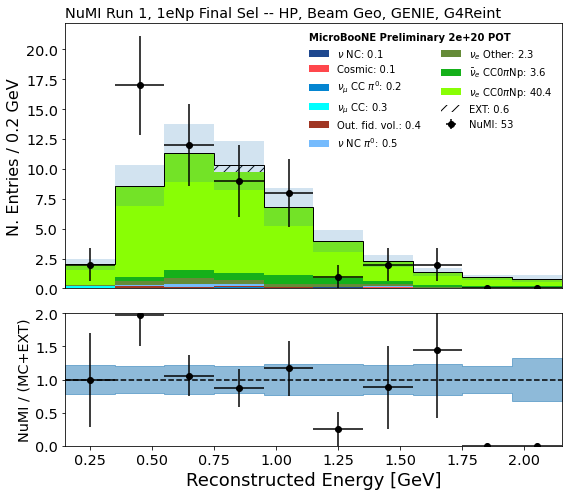

In [46]:
import matplotlib.pyplot as plt
import matplotlib

# DID YOU CHANGE BACK THE SYSTEMATICS???


#VARIABLE, BINS, RANGE, XTIT = 'nonpi0_score',10,(0,1.0),"non-$\pi^0$ BDT response"
#VARIABLE, BINS, RANGE, XTIT = 'pi0_score',10,(0,1.0),"$\pi^0$ BDT response"
#VARIABLE, BINS, RANGE, XTIT = 'reco_e', 10, (0.15,2.30), r"Reconstructed Energy [GeV]"
#VARIABLE, BINS, RANGE, XTIT = 'protonenergy',10,(0.,0.5),"Proton Kinetic Energy [GeV]"




QUERY = BDTCQ +" and "+NPLCUTQ #+"and shr_theta >1.8"
#QUERY = 'nslice == 1'
#VARIABLE, BINS, RANGE, XTIT = 'reco_e', 10, (0.15,2.50), r"Reconstructed Energy [GeV]"
#VARIABLE, BINS, RANGE, XTIT = 'reco_e', 10, (0.15,2.15), r"Reconstructed Energy [GeV]"
#VARIABLE, BINS, RANGE, XTIT = 'reco_e', 4, (0.15,0.95), r"Reconstructed Energy [GeV]"
#VARIABLE, BINS, RANGE, XTIT = 'reco_e', 4, (0.,0.8), r"Reconstructed Energy [GeV]"
VARIABLE, BINS, RANGE, XTIT = 'reco_e', 10, (0.15,2.15), r"Reconstructed Energy [GeV]"

fig, ax1, ax2 = my_plotter.plot_variable(
    VARIABLE,   
    query= QUERY ,
    kind="event_category",
    draw_sys  = True, 
    draw_geoSys = True, 
    #draw_data = False,
    genieweight = "weightSplineTimesTuneTimesPPFX", #"weightSplineTimesTuneTimesPPFX", 
    stacksort=3,
    title=XTIT,
    bins=BINS,
    range=RANGE,
)[0:3]

#ax1.set_title('NuMI Run 1, 1eNp Final Sel -- Nue Intrinsic --  HP,XSec,G4 Syst',loc='left')
ax1.set_title('NuMI Run 1, 1eNp Final Sel -- HP, Beam Geo, GENIE, G4Reint',loc='left')
fig.tight_layout()
fig.savefig("/Users/elenag/Desktop/NuMI/NuMI4PeLEE/Sidebands/Figures/NuMI/1eNp/BDTFinalFullMC/"+VARIABLE+"_varCV.pdf")
#print('%s %.4f %.4f %.4f ' % (VARIABLE, my_plotter.stats['pvalue'], my_plotter.stats['pvaluestatonly'],my_plotter.stats['pvaluediag'])+"\n")

In [ ]:
mcVar  = nue.query(QUERY)

import matplotlib.pyplot as plt
import matplotlib




fig, ax = plt.subplots(nrows=2, sharex=True,figsize=(14,14))

n2, bins2, patches2 = ax[0].hist(mcVar['reco_e'],10,density=False,weights=mcVar['var1'],  range=(0.15,2.15), fill=False, label='Var1')
n2, bins2, patches2 = ax[0].hist(mcVar['reco_e'],10,density=False,weights=mcVar['var2'],  range=(0.15,2.15), fill=False, label='Var2')
n2, bins2, patches2 = ax[0].hist(mcVar['reco_e'],10,density=False,weights=mcVar['var3'],  range=(0.15,2.15), fill=False, label='Var3')
n2, bins2, patches2 = ax[0].hist(mcVar['reco_e'],10,density=False,weights=mcVar['var4'],  range=(0.15,2.15), fill=False, label='Var4')
n2, bins2, patches2 = ax[0].hist(mcVar['reco_e'],10,density=False,weights=mcVar['var5'],  range=(0.15,2.15), fill=False, label='Var5')
n2, bins2, patches2 = ax[0].hist(mcVar['reco_e'],10,density=False,weights=mcVar['var6'],  range=(0.15,2.15), fill=False, label='Var6')
n2, bins2, patches2 = ax[0].hist(mcVar['reco_e'],10,density=False,weights=mcVar['var7'],  range=(0.15,2.15), fill=False, label='Var7')
n2, bins2, patches2 = ax[0].hist(mcVar['reco_e'],10,density=False,weights=mcVar['var8'],  range=(0.15,2.15), fill=False, label='Var8')
n2, bins2, patches2 = ax[0].hist(mcVar['reco_e'],10,density=False,weights=mcVar['var9'],  range=(0.15,2.15), fill=False, label='Var9')
n2, bins2, patches2 = ax[0].hist(mcVar['reco_e'],10,density=False,weights=mcVar['var10'],  range=(0.15,2.15), fill=False, label='Var10')
n2, bins2, patches2 = ax[0].hist(mcVar['reco_e'],10,density=False,weights=mcVar['var11'],  range=(0.15,2.15), fill=False, label='Var11')
n2, bins2, patches2 = ax[0].hist(mcVar['reco_e'],10,density=False,weights=mcVar['var12'],  range=(0.15,2.15), fill=False, label='Var12')
n2, bins2, patches2 = ax[0].hist(mcVar['reco_e'],10,density=False,weights=mcVar['var13'],  range=(0.15,2.15), fill=False, label='Var13')
n2, bins2, patches2 = ax[0].hist(mcVar['reco_e'],10,density=False,weights=mcVar['var14'],  range=(0.15,2.15), fill=False, label='Var14')
n2, bins2, patches2 = ax[0].hist(mcVar['reco_e'],10,density=False,weights=mcVar['var15'],  range=(0.15,2.15), fill=False, label='Var15')
n2, bins2, patches2 = ax[0].hist(mcVar['reco_e'],10,density=False,weights=mcVar['var16'],  range=(0.15,2.15), fill=False, label='Var16')
n2, bins2, patches2 = ax[0].hist(mcVar['reco_e'],10,density=False,weights=mcVar['var17'],  range=(0.15,2.15), fill=False, label='Var17')
n2, bins2, patches2 = ax[0].hist(mcVar['reco_e'],10,density=False,weights=mcVar['var18'],  range=(0.15,2.15), fill=False, label='Var18')
n2, bins2, patches2 = ax[0].hist(mcVar['reco_e'],10,density=False,weights=mcVar['var19'],  range=(0.15,2.15), fill=False, label='Var19')
n2, bins2, patches2 = ax[0].hist(mcVar['reco_e'],10,density=False,weights=mcVar['var20'],  range=(0.15,2.15), fill=False, label='Var20')
n1, bins1, patches1 = ax[0].hist(mcVar['reco_e'],10,density=False,weights=mcVar['weightSplineTimesTuneTimesPPFX'],  range=(0.15,2.15),linewidth=2,edgecolor='red', fill=False, label='CV')
ax[0].set_xlabel('reco_e [GeV]')
ax[0].set_ylabel('un normalized counts')
ax[0].set_title('Signal Only, CV and Variations')
ax[0].legend()
ax[0].grid(True)



In [ ]:
QUERY2 =QUERY+' and evt == 2008' 
w = mcVar.query(QUERY2)[["weightsNuMIGeo"]].to_string()
print(w)

In [ ]:
print('%s P-value Full Cov = %.4f Stat Only = %.4f Diag Only = %.4f ' % (VARIABLE, my_plotter.stats['pvalue'], my_plotter.stats['pvaluestatonly'],my_plotter.stats['pvaluediag']))

In [ ]:
mcVar  = nue.query(QUERY)

In [ ]:
QUERY2 = "nslice>=0" # QUERY + " and reco_e < 0.250" #"and ((true_nu_px+true_nu_py + true_nu_pz) < 0.350)"
#print (QUERY)
#newNueDF = nue.query(QUERY2)[["run","sub","evt","reco_e","true_nu_px","true_nu_py","true_nu_pz","weightSplineTimesTuneTimesPPFX"]]
newNueDF = nue.query(QUERY2)[["reco_e","true_nu_px","true_nu_py","true_nu_pz","weightSplineTimesTuneTimesPPFX"]]

In [ ]:
newNueDF["true_nu_e"] = newNueDF["true_nu_px"] + newNueDF["true_nu_py"] + newNueDF["true_nu_pz"] 

In [ ]:
print(min(newNueDF["true_nu_e"]))
#print(sum(newNueDF["weightSplineTimesTuneTimesPPFX"]))

In [ ]:
newNueDFSorted = newNueDF.sort_values("true_nu_e")
print(newNueDFSorted)

In [ ]:
fiduc = "true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x < \
 254.8 and true_nu_vtx_x > -1.55"

q2 = "(abs(nu_pdg) == 12 and ccnc == 0) and " + fiduc

q2 = fiduc +" and "+NPLCUTQ + " and (abs(nu_pdg) == 12 and ccnc == 0)" #" and" + fiduc
#q2 = "(abs(nu_pdg) == 12 and ccnc == 0) and " + fiduc
#q2 = BDTCQ +" and "+NPLCUTQ + " and (abs(nu_pdg) == 12 and ccnc == 0)" #" and" + fiduc
#q2 = "(abs(nu_pdg) == 12 and ccnc == 0) and " + NPLCUTQ
#print (NPLCUTQ)
nueMCSel  = mc.query(q2)
nueSel    = nue.query(q2)
nueMCSelO = mcO.query(q2)
nueSelO   = nueO.query(q2)

In [ ]:
fiduc = "true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x < \
 254.8 and true_nu_vtx_x > -1.55"


q2 = fiduc +" and "+ BDTCQ +" and "+ NPLCUTQ + " and (abs(nu_pdg) == 12 and ccnc == 0)" #" and" + fiduc
#q2 = "(abs(nu_pdg) == 12 and ccnc == 0) and " + fiduc
#q2 = BDTCQ +" and "+NPLCUTQ + " and (abs(nu_pdg) == 12 and ccnc == 0)" #" and" + fiduc
#q2 = "(abs(nu_pdg) == 12 and ccnc == 0) and " + NPLCUTQ
#print (NPLCUTQ)
nueMCSel  = mc.query(q2)
nueSel    = nue.query(q2)

import matplotlib.pyplot as plt
import matplotlib




fig, ax = plt.subplots(nrows=5, sharex=True,figsize=(14,24))
n1, bins1, patches1 = ax[0].hist(nueSel['true_e_visible'],25,density=True,weights=nueSel['weightSplineTimesTuneTimesPPFX'],  range=(0,5), alpha=0.75, label='nue intrinsic')
n2, bins2, patches2 = ax[0].hist(nueMCSel['true_e_visible'],25,density=True,weights=nueMCSel['weightSplineTimesTuneTimesPPFX'],  range=(0,5), alpha=0.75, label='full MC nues New Tune')
ax[0].set_xlabel('true_e_visible [GeV]')
ax[0].set_ylabel('normalized counts')
ax[0].set_title('Only Truth Selection [Fid+cc]')
ax[0].legend()
ax[0].grid(True)

ratio = n1/n2 
ax[1].bar(x=xs, height=ratio,width=ws)
ax[1].set_ylabel('Nue/MC New Tune')
ax[1].set_xlabel('true_e_visible [GeV]')
ax[1].set_yticks([0,5,7.8,10])
ax[1].grid(True)


In [ ]:
import matplotlib.pyplot as plt
import matplotlib

fig, ax = plt.subplots(nrows=5, sharex=True,figsize=(14,24))

#n1, bins1, patches1 = ax[0].hist(nueSel['true_e_visible'],25,weights=nueSel['weightSplineTimesTune'],  range=(0,5), alpha=0.75, label='nue intrinsic')
#n1O, bins1O, patches1O = ax[0].hist(nueSelO['true_e_visible'],25,weights=nueSelO['weightSplineTimesTune'],  range=(0,5), alpha=0.75, label='nue intrinsic O')
#n2O, bins2O, patches2O = ax[0].hist(nueMCSelO['true_e_visible'],25,weights=nueMCSelO['weightSplineTimesTune'],  range=(0,5), alpha=0.75, label='full MC nues Old Tune')
#n2, bins2, patches2 = ax[0].hist(nueMCSel['true_e_visible'],25,weights=nueMCSel['weightSplineTimesTune'],  range=(0,5), alpha=0.75, label='full MC nues New Tune')

n1, bins1, patches1 = ax[0].hist(nueSel['true_e_visible'],25,weights=nueSel['weightSplineTimesTuneTimesPPFX'],  range=(0,5), alpha=0.75, label='nue intrinsic')
n1O, bins1O, patches1O = ax[0].hist(nueSelO['true_e_visible'],25,weights=nueSelO['weightSplineTimesTuneTimesPPFX'],  range=(0,5), alpha=0.75, label='nue intrinsic O')
n2O, bins2O, patches2O = ax[0].hist(nueMCSelO['true_e_visible'],25,weights=nueMCSelO['weightSplineTimesTuneTimesPPFX'],  range=(0,5), alpha=0.75, label='full MC nues Old Tune')
n2, bins2, patches2 = ax[0].hist(nueMCSel['true_e_visible'],25,weights=nueMCSel['weightSplineTimesTuneTimesPPFX'],  range=(0,5), alpha=0.75, label='full MC nues New Tune')

#n1, bins1, patches1 = ax[0].hist(nueSel['true_nu_vtx_z'],25,weights=nueSel['weightSplineTimesTuneTimesPPFX'],  range=(900,1300), alpha=0.75, label='nue intrinsic')
#n2, bins2, patches2 = ax[0].hist(nueMCSel['true_nu_vtx_z'],25,weights=nueMCSel['weightSplineTimesTuneTimesPPFX'],  range=(900,1300), alpha=0.75, label='full MC nues')

ax[0].set_xlabel('true_e_visible [GeV]')
ax[0].set_ylabel('normalized counts')
ax[0].set_title('Only Truth Selection [Fid+cc]')
ax[0].legend()
ax[0].grid(True)

xs = (bins1[1:] + bins1[:-1])/2
ws = (bins1[1:] - bins1[:-1])
print(xs)

ratio = n1/n2 
ax[1].bar(x=xs, height=ratio,width=ws)
ax[1].set_ylabel('Nue/MC New Tune')
ax[1].set_xlabel('true_e_visible [GeV]')
ax[1].set_yticks([0,5,7.8,10])
ax[1].grid(True)

ratio = n1O/n2O 
ax[2].bar(x=xs, height=ratio,width=ws)
ax[2].set_ylabel('Nue/MC Old Tune')
ax[2].set_xlabel('true_e_visible [GeV]')
ax[2].set_yticks([0,5,7.8,10])
ax[2].grid(True)

ratio = n1/n1O 
ax[3].bar(x=xs, height=ratio,width=ws)
ax[3].set_ylabel('Nue: New Tune / Old Tune')
ax[3].set_xlabel('true_e_visible [GeV]')
#ax[1].set_yticks([0,5,7.8,10])
ax[3].grid(True)

ratio = n2/n2O 
ax[4].bar(x=xs, height=ratio,width=ws)
ax[4].set_ylabel('MC: New Tune / Old Tune')
ax[4].set_xlabel('true_e_visible [GeV]')
#ax[1].set_yticks([0,5,7.8,10])
plt.grid(True)

plt.show()


In [ ]:
import plotter
import importlib
importlib.reload(plotter)

QUERY = NPLCUTQ #BDTCQ +" and "+NPLCUTQ
#QUERY = "nslice >= 0" #BDTCQ #+" and "+NPLCUTQ
QUERY = NPLCUTQ
import matplotlib.pyplot as plt
import matplotlib
# v = "$\cos\left(\theta_{\mu}\right)$"

#QUERY += " & pi0truth_elec_etot<15 & npi0 == 0 & ccnc == 0"
#QUERY += " & muon_e>0.3 & npi0 == 0 & ccnc == 0"
#QUERY = "(muon_e<0.3 | pi0truth_elec_etot>=15) & npi0 == 0 & npion == 0 & ccnc == 0 & nu_pdg == 14 & category == 2"
#QUERY += " & ~((muon_e<0.3 | pi0truth_elec_etot>=15) & npi0 == 0 & npion == 0 & ccnc == 0 & nu_pdg == 14 & category != 5)"


VARIABLE, BINS, RANGE, XTIT = 'reco_e', 10, (0.15,2.15), r"Reconstructed Energy [GeV]"
#VARIABLE, BINS, RANGE, XTIT = 'reco_nu_vtx_sce_y',12,(-120,120),"y [cm]"
#VARIABLE, BINS, RANGE, XTIT = 'flash_time',1,(0,20.),"flash time"


#VARIABLE, BINS, RANGE, XTIT = 'pi0_mass_Y',100,(0,1000.),"pi0 mass Y"
#VARIABLE, BINS, RANGE, XTIT = 'pi0_dedx1_fit_Y',25,(0,10.),"pi0 dedx1 fit Y"
#VARIABLE, BINS, RANGE, XTIT = 'trk_len',50,(0,400.),"track length"

#VARIABLE, BINS, RANGE, XTIT = 'pi0_gammadot',10,(-1.,1.0),r" pi0 gammadot "
#VARIABLE, BINS, RANGE, XTIT = 'topological_score',25,(0,1),r"topological score"
#VARIABLE, BINS, RANGE, XTIT = 'reco_nu_vtx_sce_x',20,(-10,260),"x"
#VARIABLE, BINS, RANGE, XTIT = 'nonpi0_score',10,(0.5,1.5),"non pi0 score"

#VARIABLE, BINS, RANGE, XTIT = 'n_showers_contained',10,(0.,10.),r"n showers contained"
#VARIABLE, BINS, RANGE, XTIT = 'pi0truth_elec_etot',20,(0.,60),r"Michel Energy [GeV]"
#QUERY = PI0SEL #NPLCUTQ2#BDTCQ+" and "+NPLCUTQ
#fig, ax1, ax2 = my_plotter.plot_variable(
fig, ax1, ax2 = my_plotter.plot_variable(
    VARIABLE,   
    query= QUERY ,#BDTCQ,#NPLCUTQ, #QUERY, #'nslice == 1', #QUERY, #+" and category != 111",
    kind="event_category",
    #kind="sample",
    #kind="interaction",
    #kind='particle_pdg',
    draw_sys=True, #False,
    genieweight = "weightSplineTimesTuneTimesPPFX", #"noW", #"weightSplineTimesTuneTimesPPFX",
    stacksort=3,
    title=XTIT,
    #bins=asymm_bins,
    bins=BINS,
    range=RANGE,
)[0:3]

#print("Profile likelihood: %.2f sigma @ 1.01e21 POT" % my_plotter.significance_likelihood)
#print("s/sqrt(b): %.2f sigma @ 1.01e21 POT" % my_plotter.significance)

#ax1.set_ylim(0,40)
#ax1.set_yscale("log")
#ax1.set_ylim(0,240)
#ax1.set_yscale('log')
#ax1.set_ylim(0,ax1.get_ylim()[1]*1.25)
#ax2.set_ylim(0.,2.)

#ax1.set_title('NuMI Run 1 \n1eNp BDT Sel - $\pi^0$ Scaling: [1-0.4 E$_{\pi^0}$ ], Stat only',loc='left')
ax1.set_title('NuMI 1eNp Selection -- weightSplineTimesTuneTimesPPFX',loc='left')
fig.tight_layout()
#fig.savefig("/Users/elenag/Desktop/NuMI/NuMI4PeLEE/Sidebands/Figures/NuMI/1eNp/BDTFinal/"+VARIABLE+"_S_ReintFluxXsPPFX.pdf")
#fig.savefig("/Users/elenag/Desktop/NuMI/NuMI4PeLEE/Sidebands/Figures/NuMI/Pi0/"+VARIABLE+"_noScale.pdf")

In [ ]:
fiduc = "true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x < \
 254.8 and true_nu_vtx_x > -1.55"


#q2 = BDTCQ +" and "+ NPLCUTQ + " and (abs(nu_pdg) == 12 and ccnc == 0)"

q2 = "(abs(nu_pdg) == 12 and ccnc == 0)"

#print (NPLCUTQ)
nueMCSel  = mc.query(q2)
nueSel    = nue.query(q2)

import matplotlib.pyplot as plt
import matplotlib




fig, ax = plt.subplots(nrows=3, sharex=False,figsize=(14,24))
n1, bins1, patches1 = ax[0].hist(nueSel['true_nu_vtx_z'],120,weights=nueSel['weightSplineTimesTuneTimesPPFX'],  range=(-50,1100), alpha=0.75, label='nue intrinsic')
n2, bins2, patches2 = ax[0].hist(nueMCSel['true_nu_vtx_z'],120,weights=nueMCSel['weightSplineTimesTuneTimesPPFX'],  range=(-50,1100), alpha=0.75, label='full MC nues New Tune')
ax[0].set_xlabel('True vtx Z [cm]')
ax[0].set_ylabel('normalized counts')
ax[0].set_title('Only Truth Selection [Fid+cc]')
ax[0].legend()
ax[0].grid(True)

n1, bins1, patches1 = ax[1].hist(nueSel['true_nu_vtx_y'],120,weights=nueSel['weightSplineTimesTuneTimesPPFX'],  range=(-120,120), alpha=0.75, label='nue intrinsic')
n2, bins2, patches2 = ax[1].hist(nueMCSel['true_nu_vtx_y'],120,weights=nueMCSel['weightSplineTimesTuneTimesPPFX'],  range=(-120,120), alpha=0.75, label='full MC nues New Tune')
ax[1].set_xlabel('True vtx Y [cm] ')
ax[1].set_ylabel('normalized counts')
ax[1].set_title('Only Truth Selection [Fid+cc]')
ax[1].legend()
ax[1].grid(True)

n1, bins1, patches1 = ax[2].hist(nueSel['true_nu_vtx_x'],270,weights=nueSel['weightSplineTimesTuneTimesPPFX'],  range=(0,270), alpha=0.75, label='nue intrinsic')
n2, bins2, patches2 = ax[2].hist(nueMCSel['true_nu_vtx_x'],270,weights=nueMCSel['weightSplineTimesTuneTimesPPFX'],  range=(0,270), alpha=0.75, label='full MC nues New Tune')
ax[2].set_xlabel('True vtx X [cm] ')
ax[2].set_ylabel('normalized counts')
ax[2].set_title('Only Truth Selection [Fid+cc]')
ax[2].legend()
ax[2].grid(True)

In [ ]:
#VARIABLE, BINS, RANGE, XTIT = 'reco_e', 10, (0.15,2.15), r"Reconstructed Energy [GeV]"
VARIABLE, BINS, RANGE, XTIT = 'subcluster',15,(0,60),r"N sub-clusters in shower"


fig, ax1, ax2 = my_plotter.plot_variable(
    VARIABLE,   
    query= QUERY ,
    kind="event_category",
    draw_sys=False,
    stacksort=3,
    title=XTIT,
    #bins=asymm_bins,
    bins=BINS,
    range=RANGE,
)[0:3]

ax1.set_title('NuMI Run 1 \n1eNp BDT Sel - $\pi^0$ Scaling: [1-0.4 E$_{\pi^0}$ ], Stat Only',loc='left')
#fig.savefig("/Users/elenag/Desktop/NuMI/NuMI4PeLEE/Sidebands/Figures/NuMI/1eNp/BDTSel/"+VARIABLE+".pdf")

In [ ]:
print('%s %.4f ' % (VARIABLE, my_plotter.stats['pvaluestatonly']))

In [ ]:
print(NPLCUTQ)
print()
print(BDTCQ)
print()
print(myPre)

In [ ]:
#print(data.query(QUERY)[["run","sub","evt","reco_e"]])
#QUERY += " and shr_theta > 1.5"
print(data.query(QUERY)[["run","sub","evt","nu_pdg"]])
f = data.query(QUERY)[["run","sub",]]
#tablevars = ["run","sub","evt","reco_e","pi0_score","nonpi0_score"]
#tablevars = ["run","sub","evt"]
#tablevars+=TRAINVAR
#print(tablevars)
#data.query(PRESQ+" & run==14822")[tablevars]
#data.query("run==5151")[tablevars]

query4SamWeb = f.apply(lambda x: str(x['run'])+'.'+str(x['sub'])+',', axis=1).sum()
print("defname: numi_uboone_run1_beamon_offset1_mcc9_reco2_v08_00_00_28_beam_good and run_number "+query4SamWeb)


In [ ]:
mc.query(QUERY+"& ccnc==0 & nu_pdg==14 & mcf_np0==0")[["run","sub","evt","reco_e","mcf_lep_e","mcf_mcshr_elec_etot"]]

In [ ]:
QUERY = BDTCQ +" and "+NPLCUTQ #+" and shr_energy_tot_cali < 0.5"
#QUERY = NPLCUTQ #BDTCQ +" and "+NPLCUTQ
plots = []

plots.append(['reco_nu_vtx_sce_x',10,(0,260),"vtx x [cm]"])
plots.append(['reco_nu_vtx_sce_y',10,(-120,120),"vtx y [cm]"])
plots.append(['reco_nu_vtx_sce_z',10,(0,1030),"vtx z [cm]"])
#VARIABLE, BINS, RANGE, XTIT = 'reco_nu_vtx_sce_x',5,(0,260),"vtx x [cm]"
#VARIABLE, BINS, RANGE, XTIT = 'reco_nu_vtx_sce_y',5,(-120,120),"vtx y [cm]"
#VARIABLE, BINS, RANGE, XTIT = 'reco_nu_vtx_sce_z',5,(0,1030),"vtx z [cm]"

'''
plots.append(['shr_score',20,(0,0.5),"shr score"])
plots.append(['tksh_distance',10,(0,5),"tksh distance [cm]"])
plots.append(['tksh_angle',10,(-1,1),"cos(tksh angle)"])
plots.append(['shr_tkfit_dedx_max',20,(0,10),"shr tkfit dE/dx (best-plane, 0-4 cm) [MeV/cm]"])
plots.append(['trkfit',10,(0,1),"Fraction of Track-fitted points"])
plots.append(['trkpid',10,(-1,1),"track LLR PID"])
plots.append(['shrmoliereavg',10,(0,25),"average Moliere angle [degrees]"])
plots.append(['subcluster',15,(0,60),"N sub-clusters in shower"])
plots.append(['hits_ratio',20,(0,1),"shower hits/all hits"])
plots.append(['trkshrhitdist2',16,(-1,15),"2D trk-shr distance (Y)"])
plots.append(['secondshower_Y_nhit',20,(0,200),"Nhit 2nd shower (Y)"])
plots.append(['secondshower_Y_dot',20,(-1,1),"cos(2nd shower direction wrt vtx) (Y)"])
plots.append(['secondshower_Y_vtxdist',20,(0.,400),"vtx dist 2nd shower (Y)"])
plots.append(['anglediff_Y',10,(0,360),"angle diff 1st-2nd shower (Y) [degrees]"])
plots.append(['CosmicIPAll3D',10,(0,200),"CosmicIPAll3D [cm]"])
plots.append(['CosmicDirAll3D',10,(-1,1),"cos(CosmicDirAll3D)"])
plots.append(['reco_nu_vtx_sce_y',15,(-150,150),"reco nu vtx y [cm]"])
'''
#plots.append(['shr_tkfit_dedx_Y',20,(0,10),"shr tkfit dE/dx (Y, 0-4 cm) [MeV/cm]"])
#plots.append(['shr_tkfit_dedx_U',20,(0,10),"shr tkfit dE/dx (U, 0-4 cm) [MeV/cm]"])
#plots.append(['shr_tkfit_dedx_V',20,(0,10),"shr tkfit dE/dx (V, 0-4 cm) [MeV/cm]"])
#plots.append(['shr_tkfit_2cm_dedx_Y',20,(0,10),"shr tkfit dE/dx (Y, 0-2 cm) [MeV/cm]"])
#plots.append(['shr_tkfit_2cm_dedx_U',20,(0,10),"shr tkfit dE/dx (U, 0-2 cm) [MeV/cm]"])
#plots.append(['shr_tkfit_2cm_dedx_V',20,(0,10),"shr tkfit dE/dx (V, 0-2 cm) [MeV/cm]"])
#plots.append(['shr_tkfit_gap10_dedx_Y',20,(0,10),"shr tkfit dE/dx (Y, 1-5 cm) [MeV/cm]"])
#plots.append(['shr_tkfit_gap10_dedx_U',20,(0,10),"shr tkfit dE/dx (U, 1-5 cm) [MeV/cm]"])
#plots.append(['shr_tkfit_gap10_dedx_V',20,(0,10),"shr tkfit dE/dx (V, 1-5 cm) [MeV/cm]"])
#plots.append(['shr_tkfit_dedx_avg',20,(0,10),"shr tkfit dE/dx (avg, 0-4 cm) [MeV/cm]"])
#plots.append(['shr_tkfit_nhits_tot',20,(0,20),"shr tkfit nhits (tot, 0-4 cm) [MeV/cm]"])
#plots.append(['shr_tkfit_2cm_dedx_avg',20,(0,10),"shr tkfit dE/dx (avg, 0-2 cm) [MeV/cm]"])
#plots.append(['shr_tkfit_2cm_nhits_tot',20,(0,20),"shr tkfit nhits (tot, 0-2 cm) [MeV/cm]"])
#plots.append(['shr_tkfit_gap10_dedx_avg',20,(0,10),"shr tkfit dE/dx (avg, 1-5 cm) [MeV/cm]"])
#plots.append(['shr_tkfit_gap10_nhits_tot',20,(0,20),"shr tkfit nhits (tot, 1-5 cm) [MeV/cm]"])
#plots.append(['shr_tkfit_nhits_tot',20,(0,20),"shr tkfit nhits (tot, 0-4 cm) [MeV/cm]"])
#plots.append(['shr_tkfit_dedx_max',20,(0,10),"shr tkfit dE/dx (best-plane, 0-4 cm) [MeV/cm]"])
#plots.append(['n_showers_contained',10,(0,10),"n showers contained"])
plots.append(['n_tracks_contained',5,(0,5),"n tracks contained"])
plots.append([ 'trk_energy_tot',12,(0,0.6), "Total kinetic energy in protons [GeV]"])
plots.append(['protonenergy',10,(0.,0.5),"Proton Kinetic Energy [GeV]"])
plots.append(['trk_theta',10,(0,3.15),"Track theta"])
plots.append(['pt',10,(0,2.),"Pt [GeV]"])
plots.append(['protontheta',10,(0,3.15),"Leading Proton Theta [rad]"])
plots.append(['protonphi',10,(-3.15,3.15),"Leading Proton Phi [rad]"])
plots.append(['shr_theta',10,(0,3.15),"Shower Theta [rad]"])
plots.append(['shr_phi',10,(-3.15,3.15),"Shower Phi [rad]"])
plots.append(['shr_numi_Angle', 10, (0.,180.), "NuMI Shower Angle [deg]"])
plots.append(['proton_numi_Angle', 10, (0.,180.), "NuMI Proton Angle [deg]"])
#VARIABLE, BINS, RANGE, XTIT = 'numi_Angle', 10, (0.,180.), r"NuMI Angle [deg]"
#plots.append(['reco_nu_vtx_sce_x',5,(0,260),"vtx x [cm]"])
#plots.append(['reco_nu_vtx_sce_y',5,(-120,120),"vtx y [cm]"])
#plots.append(['reco_nu_vtx_sce_z',5,(0,1030),"vtx z [cm]"])

#plots.append(['reco_nu_vtx_sce_z',20,(0,1100),"z"])
#plots.append(['reco_e_rqe',20,(0,2),"rqe"])
#plots.append(['shrmoliererms',20,(0,5000),"RMS Moliere angle [degrees]"])
plots.append(['shr_energy_tot_cali',10,(0,2),"shr energy (calibrated) [GeV]"])
plots.append(['reco_e', 10, (0.15,2.15), 'Reconstructed Energy [GeV]'])
#plots.append(['contained_fraction',20,(0.,1),"contained fraction"])
#plots.append(['hits_y',20,(0.,1000),"N hits Y plane"])
#plots.append(['pi0_mass_Y',25,(-50.,200),"pi0 mass [Mev]"])
#plots.append(['pi0_gammadot',20,(-1,1),"2-shower angle"])
if USEBDT:
    #plots = []
    #plots.append(['pi0_score',20,(0.9,1),"$\pi^0$ BDT response"])
    #plots.append(['nonpi0_score',20,(0.9,1),"non-$\pi^0$ BDT response"])
    #plots.append(['pi0_score',10,(0.,0.5),"$\pi^0$ BDT response"])
    #plots.append(['nonpi0_score',10,(0.,0.5),"non-$\pi^0$ BDT response"])
    plots.append(['pi0_score',10,(0,1.0),"$\pi^0$ BDT response"])
    plots.append(['nonpi0_score',10,(0,1.0),"non-$\pi^0$ BDT response"])

#plots.append([ 'protontheta',10,(0,3.0), "Leading proton theta [rad]"])
#plots.append([ 'protonphi',10,(-3.0,3.0), "Leading proton phi [rad]"])

    #plots = []
#plots.append(['tksh_distance',20,(0,10),"tksh distance [cm]"])

#plots.append(['secondshower_Y_nhit',20,(0,200),"Nhit 2nd shower (Y)"])
#plots.append(['secondshower_Y_dot',20,(-1,1),"cos(2nd shower direction wrt vtx) (Y)"])
#plots.append(['anglediff_Y',20,(0,350),"angle diff 1st-2nd shower (Y) [degrees]"])
#plots.append(['secondshower_Y_vtxdist',20,(0.,200),"vtx dist 2nd shower (Y)"])
f = open("/Users/elenag/Desktop/NuMI/NuMI4PeLEE/Sidebands/Figures/NuMI/1eNp/BDTFinalFullMC/NuMIPValuesSys_1eNp.txt", "w")
for VARIABLE, BINS, RANGE, XTIT in plots:
    print(VARIABLE, BINS, RANGE, XTIT)
    fig, ax1, ax2 = my_plotter.plot_variable(
        VARIABLE,   
        query=QUERY,
        kind="event_category",
        genieweight = "weightSplineTimesTuneTimesPPFX",
        #kind="interaction",
        #kind="sample",
        draw_sys=True,
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE,
    )[0:3]
    #ax1.set_ylim(0,ax1.get_ylim()[1]*1.4)
    #ax1.set_yscale("log")
    #fig.show()
    #ax1.set_title('NuMI Run 1 \n1eNp Loose Box Cuts - No pi0 scaling',loc='left')
    ax1.set_title('NuMI Run 1, 1eNp Final Sel -- HP,XSec,G4 Syst',loc='left')
    fig.tight_layout()
    #fig.savefig("/Users/elenag/Desktop/NuMI/NuMI4PeLEE/Sidebands/Figures/NuMI/1eNp/"+VARIABLE+".pdf")
    fig.savefig("/Users/elenag/Desktop/NuMI/NuMI4PeLEE/Sidebands/Figures/NuMI/1eNp/BDTFinalFullMC/"+VARIABLE+"_S_FullMC_ReintFluxXsPPFX.pdf")
    #fig.savefig(ls.plots_path+""+VARIABLE+"_highscore.pdf")
    #f.write('%s %.4f ' % (VARIABLE, my_plotter.stats['pvaluestatonly'])+"\n")
    f.write('%s %.4f %.4f %.4f ' % (VARIABLE, my_plotter.stats['pvalue'], my_plotter.stats['pvaluestatonly'],my_plotter.stats['pvaluediag'])+"\n")
    #break
f.close()

In [ ]:
QUERY = BDTCQ+" and "+NPLCUTQ+" and shr_theta > 1.8"
print(QUERY)
f = data.query(QUERY)[["shr_px","shr_py","shr_pz"]] #,"reco_e","shr_theta","shr_phi"]]#.to_string(index=False)
f = data.query(QUERY)[["shr_phi","shr_theta"]]
#query4SamWeb = f.apply(lambda x: str(x['run'])+'.'+str(x['sub'])+',', axis=1).sum()
#print("defname: numi_uboone_run1_beamon_offset1_mcc9_reco2_v08_00_00_28_v0 and run_number "+query4SamWeb)

#f = data.query(QUERY)[["run","sub","evt","reco_e"]]
print (f)

In [ ]:
from scipy.spatial.transform import Rotation as R
from numpy import arccos, array
from numpy.linalg import norm

# Note: returns angle in radians
def theta(v, w): return arccos(v.dot(w)/(norm(v)*norm(w)))* 180 / 3.1415926

def GetNuMIAngle( px,  py,  pz):
    r = R.from_matrix([[0.92103853804025681562   , 0.022713504803924120662, 0.38880857519374290021  ],
                       [4.6254001262154668408e-05, 0.99829162468141474651 , -0.058427989452906302359],
                       [-0.38947144863934973769  , 0.053832413938664107345, 0.91946400794392302291  ]])  
    r = r.inv()
    beamCoords = r.apply([px,  py,  pz])
    beamDir    = [0,0,1]
    #print(theta(beamCoords,beamDir))
    return theta(beamCoords,beamDir)



#df_v = [mc,nue,ext,data,dirt]
#for i,df in enumerate(df_v):
#    df['numi_Angle'] = GetNuMIAngle(df['shr_px'],df['shr_py'],df['shr_pz'])

In [ ]:
scaleFlat = 2
df_v = [mc,nue,mcO,nueO,dirt]
#removeGenieTune = False
for i,df in enumerate(df_v):
    if scaleFlat == 1:
        df['weightSplineTimesTune'] = df[ 'currentweight' ] 
        df.loc[ df['npi0'] > 0, 'weightSplineTimesTune' ] =  (df['weightSplineTimesTune'] * 0.759)
    elif scaleFlat == 2:
        df['weightSplineTimesTune'] = df[ 'currentweight' ] 
        pi0emax = 0.6
        df.loc[ (df['pi0_e'] > 0.1) & (df['pi0_e'] < pi0emax) , 'weightSplineTimesTune'] = df['weightSplineTimesTune']*(1.-0.4*df['pi0_e'])
        df.loc[ (df['pi0_e'] > 0.1) & (df['pi0_e'] >= pi0emax), 'weightSplineTimesTune'] = df['weightSplineTimesTune']*(1.-0.4*pi0emax)
    elif scaleFlat == 0:
        df['weightSplineTimesTune'] = df[ 'currentweight' ] 


In [ ]:
QUERY = BDTCQ +" and "+NPLCUTQ
plots = []
plots.append(['shr_theta',100,(0.,3.0),"Shower theta"])
plots.append(['shr_phi',10,(-3,3),"Shower phi"])
'''
plots.append(['reco_e', 10, (0.15,2.15), 'Reconstructed Energy [GeV]'])
plots.append(['shr_score',20,(0,0.5),"shr score"])
plots.append(['tksh_distance',5,(0,5),"tksh distance [cm]"])
plots.append(['tksh_angle',10,(-1,1),"cos(tksh angle)"])
plots.append(['shr_tkfit_dedx_max',15,(0,10),"shr tkfit dE/dx (best-plane, 0-4 cm) [MeV/cm]"])
plots.append(['trkfit',10,(0,1),"Fraction of Track-fitted points"])
plots.append(['trkpid',10,(-1,1),"track LLR PID"])
plots.append(['shrmoliereavg',10,(0,25),"average Moliere angle [degrees]"])
plots.append(['subcluster',15,(0,60),"N sub-clusters in shower"])
plots.append(['hits_ratio',20,(0,1),"shower hits/all hits"])
plots.append(['trkshrhitdist2',16,(-1,15),"2D trk-shr distance (Y)"])
plots.append(['secondshower_Y_nhit',20,(0,200),"Nhit 2nd shower (Y)"])
plots.append(['secondshower_Y_dot',20,(-1,1),"cos(2nd shower direction wrt vtx) (Y)"])
plots.append(['secondshower_Y_vtxdist',20,(0.,400),"vtx dist 2nd shower (Y)"])
plots.append(['anglediff_Y',10,(0,360),"angle diff 1st-2nd shower (Y) [degrees]"])
plots.append(['CosmicIPAll3D',10,(0,200),"CosmicIPAll3D [cm]"])
plots.append(['CosmicDirAll3D',10,(-1,1),"cos(CosmicDirAll3D)"])
plots.append(['reco_nu_vtx_sce_y',15,(-150,150),"reco nu vtx y [cm]"])
             
#plots.append(['shr_tkfit_dedx_Y',20,(0,10),"shr tkfit dE/dx (Y, 0-4 cm) [MeV/cm]"])
#plots.append(['shr_tkfit_dedx_U',20,(0,10),"shr tkfit dE/dx (U, 0-4 cm) [MeV/cm]"])
#plots.append(['shr_tkfit_dedx_V',20,(0,10),"shr tkfit dE/dx (V, 0-4 cm) [MeV/cm]"])
#plots.append(['shr_tkfit_2cm_dedx_Y',20,(0,10),"shr tkfit dE/dx (Y, 0-2 cm) [MeV/cm]"])
#plots.append(['shr_tkfit_2cm_dedx_U',20,(0,10),"shr tkfit dE/dx (U, 0-2 cm) [MeV/cm]"])
#plots.append(['shr_tkfit_2cm_dedx_V',20,(0,10),"shr tkfit dE/dx (V, 0-2 cm) [MeV/cm]"])
#plots.append(['shr_tkfit_gap10_dedx_Y',20,(0,10),"shr tkfit dE/dx (Y, 1-5 cm) [MeV/cm]"])
#plots.append(['shr_tkfit_gap10_dedx_U',20,(0,10),"shr tkfit dE/dx (U, 1-5 cm) [MeV/cm]"])
#plots.append(['shr_tkfit_gap10_dedx_V',20,(0,10),"shr tkfit dE/dx (V, 1-5 cm) [MeV/cm]"])
#plots.append(['shr_tkfit_dedx_avg',20,(0,10),"shr tkfit dE/dx (avg, 0-4 cm) [MeV/cm]"])
#plots.append(['shr_tkfit_nhits_tot',20,(0,20),"shr tkfit nhits (tot, 0-4 cm) [MeV/cm]"])
#plots.append(['shr_tkfit_2cm_dedx_avg',20,(0,10),"shr tkfit dE/dx (avg, 0-2 cm) [MeV/cm]"])
#plots.append(['shr_tkfit_2cm_nhits_tot',20,(0,20),"shr tkfit nhits (tot, 0-2 cm) [MeV/cm]"])
#plots.append(['shr_tkfit_gap10_dedx_avg',20,(0,10),"shr tkfit dE/dx (avg, 1-5 cm) [MeV/cm]"])
#plots.append(['shr_tkfit_gap10_nhits_tot',20,(0,20),"shr tkfit nhits (tot, 1-5 cm) [MeV/cm]"])
#plots.append(['shr_tkfit_nhits_tot',20,(0,20),"shr tkfit nhits (tot, 0-4 cm) [MeV/cm]"])
#plots.append(['shr_tkfit_dedx_max',20,(0,10),"shr tkfit dE/dx (best-plane, 0-4 cm) [MeV/cm]"])
#plots.append(['n_showers_contained',10,(0,10),"n showers contained"])
plots.append(['n_tracks_contained',5,(0,5),"n tracks contained"])
plots.append([ 'trk_energy_tot',12,(0,0.6), "Total kinetic energy in protons [GeV]"])
plots.append([ 'protontheta',10,(0,3.0), "Leading proton theta [rad]"])
#plots.append([ 'protonphi',10,(-3.0,3.0), "Leading proton phi [rad]"])
plots.append(['protonenergy',10,(0.,0.5),"Proton Kinetic Energy [GeV]"])
plots.append(['trk_theta',10,(0,3.0),"Track theta"])
plots.append(['shr_theta',10,(0,3.0),"Shower theta"])
plots.append(['pt',10,(0,2.),"Pt [GeV]"])
plots.append(['shr_phi',10,(-3,3),"Shower phi"])
#plots.append(['reco_nu_vtx_sce_z',20,(0,1100),"z"])
#plots.append(['reco_e_rqe',20,(0,2),"rqe"])
#plots.append(['shrmoliererms',20,(0,5000),"RMS Moliere angle [degrees]"])
plots.append(['shr_energy_tot_cali',10,(0,1),"shr energy (calibrated) [GeV]"])
#plots.append(['contained_fraction',20,(0.,1),"contained fraction"])
#plots.append(['hits_y',20,(0.,1000),"N hits Y plane"])
#plots.append(['pi0_mass_Y',25,(-50.,200),"pi0 mass [Mev]"])
#plots.append(['pi0_gammadot',20,(-1,1),"2-shower angle"])
if USEBDT:
    #plots = []
    #plots.append(['pi0_score',20,(0.9,1),"$\pi^0$ BDT response"])
    #plots.append(['nonpi0_score',20,(0.9,1),"non-$\pi^0$ BDT response"])
    #plots.append(['pi0_score',10,(0.,0.5),"$\pi^0$ BDT response"])
    #plots.append(['nonpi0_score',10,(0.,0.5),"non-$\pi^0$ BDT response"])
    plots.append(['pi0_score',10,(0,1.0),"$\pi^0$ BDT response"])
    plots.append(['nonpi0_score',10,(0,1.0),"non-$\pi^0$ BDT response"])
'''
#plots = []
#plots.append(['tksh_distance',20,(0,10),"tksh distance [cm]"])

#plots.append(['secondshower_Y_nhit',20,(0,200),"Nhit 2nd shower (Y)"])
#plots.append(['secondshower_Y_dot',20,(-1,1),"cos(2nd shower direction wrt vtx) (Y)"])
#plots.append(['anglediff_Y',20,(0,350),"angle diff 1st-2nd shower (Y) [degrees]"])
#plots.append(['secondshower_Y_vtxdist',20,(0.,200),"vtx dist 2nd shower (Y)"])
f = open("NuMIPValuesStatOnly_1eNp.txt", "a")
for VARIABLE, BINS, RANGE, XTIT in plots:
    print(VARIABLE, BINS, RANGE, XTIT)
    fig, ax1, ax2 = my_plotter.plot_variable(
        VARIABLE,   
        query=QUERY,
        kind="event_category",
        #kind="interaction",
        #kind="sample",
        draw_sys=False,
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE,
    )[0:3]
    #ax1.set_ylim(0,ax1.get_ylim()[1]*1.4)
    #ax1.set_yscale("log")
    #fig.show()
    #ax1.set_title('NuMI Run 1 \n1eNp Loose Box Cuts - No pi0 scaling',loc='left')
    ax1.set_title('NuMI Run 1 \n1eNp BDT Sel. - $\pi^0$ Scaling: [1-0.4 E$_{\pi^0}$ ], Stat Only',loc='left')
    fig.tight_layout()
    #fig.savefig("/Users/elenag/Desktop/NuMI/NuMI4PeLEE/Sidebands/Figures/NuMI/1eNp/"+VARIABLE+".pdf")
    fig.savefig("/Users/elenag/Desktop/NuMI/NuMI4PeLEE/Sidebands/Figures/NuMI/1eNp/BDTSel_allStat/"+VARIABLE+".pdf")
    #fig.savefig(ls.plots_path+""+VARIABLE+"_highscore.pdf")
    f.write('%s %.4f ' % (VARIABLE, my_plotter.stats['pvaluestatonly'])+"\n")
    #break
f.close()

In [ ]:
QUERY =  'nslice == 1 and  n_tracks_contained == 2 and N_recoMuons == 2 and topological_score > 0.06 and N_recoProtons == 0  and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1)'
plots = []

plotsNN = []
plotsNN.append(['reco_e', 10, (0.15,2.15), 'Reconstructed Energy [GeV]'])
plotsNN.append(['topological_score', 10, (0,1), 'toposcore '])
#plotsNN.append(['reco_nu_vtx_sce_x',10,(0,260),"vtx x [cm]"])
#plotsNN.append(['reco_nu_vtx_sce_y',10,(-120,120),"vtx y [cm]"])
#plotsNN.append(['reco_nu_vtx_sce_z',10,(0,1030),"vtx z [cm]"])
plotsNN.append(['trk_energy_tot',10,(0,2.0),"Energy [GeV]"])

#f.write(" Pi0 \n")
for VARIABLE, BINS, RANGE, XTIT in plotsNN:
    print(VARIABLE, BINS, RANGE, XTIT)
    fig, ax1, ax2 = my_plotter.plot_variable(
        VARIABLE,   
        query=QUERY,
        kind="event_category",
        #kind="interaction",
        #kind="sample",
        draw_sys=False,
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE,
    )[0:3]
    ax1.set_title('NuMI Run 1 NN Sel ',loc='left')
    fig.tight_layout()
    #fig.savefig("/Users/elenag/Desktop/NuMI/NuMI4PeLEE/Sidebands/Figures/NuMI/Pi0/"+VARIABLE+"_noScale.pdf")
    print('%s %.4f ' % (VARIABLE, my_plotter.stats['pvaluestatonly'])+"\n")

In [ ]:
import pandas as pd
QUERY =  'nslice == 1 and  n_tracks_contained == 2 and N_recoMuons == 2 and topological_score > 0.06 and N_recoProtons == 0  and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1)'
print(QUERY)
data = data.query(QUERY)[:] #,"reco_e","shr_theta","shr_phi"]]#.to_string(index=False)
mc   = mc.query(QUERY)[:]
ext  = ext.query(QUERY)[:]
nue  = nue.query(QUERY)[:]
#mc['trk_calo_energy_0'] = trk_calo_energy_y_v[]

tags = mc['trk_calo_energy_y_v'].apply(pd.Series)
tags = tags.rename(columns = lambda x : 'trk_calo_energy_y_' + str(x))
pd.concat([mc[:], tags[:]], axis=1)
for col in mc.columns: 
    print(col)

In [ ]:
QUERYPlot =  'nslice == 1'
plots = []

plotsNN = []
plotsNN.append(['reco_e', 10, (0.15,2.15), 'Reconstructed Energy [GeV]'])
plotsNN.append(['topological_score', 10, (0,1), 'toposcore '])
#plotsNN.append(['reco_nu_vtx_sce_x',10,(0,260),"vtx x [cm]"])
#plotsNN.append(['reco_nu_vtx_sce_y',10,(-120,120),"vtx y [cm]"])
#plotsNN.append(['reco_nu_vtx_sce_z',10,(0,1030),"vtx z [cm]"])
plotsNN.append(['trk_energy_tot',10,(0,2.0),"Energy [GeV]"])

#f.write(" Pi0 \n")
for VARIABLE, BINS, RANGE, XTIT in plotsNN:
    print(VARIABLE, BINS, RANGE, XTIT)
    fig, ax1, ax2 = my_plotter.plot_variable(
        VARIABLE,   
        query=QUERYPlot,
        kind="event_category",
        #kind="interaction",
        #kind="sample",
        draw_sys=False,
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE,
    )[0:3]
    ax1.set_title('NuMI Run 1 NN Sel ',loc='left')
    fig.tight_layout()
    #fig.savefig("/Users/elenag/Desktop/NuMI/NuMI4PeLEE/Sidebands/Figures/NuMI/Pi0/"+VARIABLE+"_noScale.pdf")
    print('%s %.4f ' % (VARIABLE, my_plotter.stats['pvaluestatonly'])+"\n")

In [ ]:
scaling = 1

SPLIT = 1.0
if (USEBDT == True):
    SPLIT = 2.


nue = nue.query("(abs(nu_pdg) == 12 & ccnc == 0)")
samples = {
    "mc": mc,
    "nue": nue,
    "dirt": dirt,
    "data": data,
    "ext": ext
}

#scaling = 1
scaling = 0.759
pot = 8.885e+19 #9.789e+19 
mcratio   = pot/2.07136e+21
nueratio  = pot/1.85664e+22 #norm on wiki: 1.85664e+22
dirtratio = pot/1.42143e+21
extratio  = 2347745.0/4015961.99
SPLIT = 1.0
scalingEXT = 0.98
scalingDRT = 0.45

weights = { #full sample mc = 0.38
            "mc"  : mcratio  * SPLIT * scaling,   
            "nue" : nueratio * SPLIT * scaling,  
            "ext" : extratio * SPLIT * 1, #set0   
            "dirt": dirtratio* SPLIT * 1, #set0   
}

my_plotter = plotter.Plotter(samples, weights, pot=pot)
print(weights)
QUERY = PI0SEL
plots = []

plots.append(['pi0_dedx1_fit_Y',20,(0,10),"pi0 dedx1 fit Y [MeV/cm]"])
plots.append(['pi0_dedx2_fit_Y',20,(0,10),"pi0 dedx2 fit Y [MeV/cm]"])
plots.append(['tksh_distance',20,(0,60),"tksh distance [cm]"])
plots.append(['pi0_energy1_Y',26,(0.,650),"pi0 energy1 [Mev]"])    
plots.append(['pi0_energy2_Y',26,(0.,650),"pi0 energy2 [Mev]"])    
plots.append(['pi0_mass_Y',25,(0.,500),"pi0 mass [Mev]"])
plots.append(['pi0_gammadot',20,(-1,1),"2-shower angle"])

for VARIABLE, BINS, RANGE, XTIT in plots:
    print(VARIABLE, BINS, RANGE, XTIT)
    fig, ax1, ax2 = my_plotter.plot_variable(
        VARIABLE,   
        query=QUERY,
        kind="event_category",
        #kind="interaction",
        #kind="sample",
        draw_sys=False,
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE,
    )[0:3]
    ax1.set_title('NuMI Run 1 \nPi0 Sel - 0.759 pi0 scaling',loc='left')
    fig.tight_layout()
    fig.savefig("/Users/elenag/Desktop/NuMI/NuMI4PeLEE/Sidebands/Figures/NuMI/Pi0/"+VARIABLE+"_Scale.pdf")

In [ ]:
PRESQ = 'nslice == 1'
PRESQ += ' and selected == 1'
PRESQ += ' and shr_energy_tot_cali > 0.07'
PRESQ += ' and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1)'

ZPPRESEL = PRESQ
ZPPRESEL += ' and n_tracks_contained == 0'
ZPPRESEL_one_shower = ZPPRESEL + 'and n_showers_contained == 1'

ZPLOOSESEL = ZPPRESEL
ZPLOOSESEL += ' and n_showers_contained == 1'
ZPLOOSESEL += ' and CosmicIPAll3D > 10.'
ZPLOOSESEL += ' and CosmicDirAll3D > -0.9 and CosmicDirAll3D < 0.9'
ZPLOOSESEL += ' and shrmoliereavg < 15'
ZPLOOSESEL += ' and subcluster > 4'
ZPLOOSESEL += ' and trkfit < 0.65'
ZPLOOSESEL += ' and secondshower_Y_nhit < 50'
ZPLOOSESEL += ' and shr_trk_sce_start_y > -100 and shr_trk_sce_start_y < 80'
ZPLOOSESEL += ' and shr_trk_sce_end_y > -100 and shr_trk_sce_end_y < 100 '
ZPLOOSESEL += ' and shr_trk_len < 300.'
ZPLOOSESEL += ' and (n_tracks_tot == 0 or (n_tracks_tot>0 and tk1sh1_angle_alltk>-0.9))'
ZPLOOSESEL += ' and n_tracks_contained == 0'

ZPBDT = ZPLOOSESEL
ZPBDT += ' and bkg_score >0.85'

QUERY = ZPBDT

In [ ]:
scaling = 1

SPLIT = 1.0
if (USEBDT == True):
    SPLIT = 2.


nue = nue.query("(abs(nu_pdg) == 12 & ccnc == 0)")
samples = {
    "mc": mc,
    "nue": nue,
    "dirt": dirt,
    "data": data,
    "ext": ext
}

scaling = 1
#scaling = 0.759
pot = 8.885e+19 #9.789e+19 
mcratio   = pot/2.07136e+21
nueratio  = pot/1.85664e+22 #norm on wiki: 1.85664e+22
dirtratio = pot/1.42143e+21
extratio  = 2347745.0/4015961.99
SPLIT = 1.0
scalingEXT = 0.98
scalingDRT = 0.45

weights = { #full sample mc = 0.38
            "mc"  : mcratio  * SPLIT * scaling,   
            "nue" : nueratio * SPLIT * scaling,  
            "ext" : extratio * SPLIT * scalingEXT, #set0   
            "dirt": dirtratio* SPLIT * scalingDRT, #set0   
}

my_plotter = plotter.Plotter(samples, weights, pot=pot)
print(weights)
plots = []

plots.append(['reco_e',20,(0,10),"reco E [MeV]"])

for VARIABLE, BINS, RANGE, XTIT in plots:
    print(VARIABLE, BINS, RANGE, XTIT)
    fig, ax1, ax2 = my_plotter.plot_variable(
        VARIABLE,   
        query=QUERY,
        kind="event_category",
        #kind="interaction",
        #kind="sample",
        draw_sys=False,
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE,
    )[0:3]
    ax1.set_title('NuMI Run 1',loc='left')
    fig.tight_layout()

In [ ]:
for i,df in enumerate(df_v):
    df['numi_Angle'] = df.apply( lambda x: GetNuMIAngle(x['shr_px'],x['shr_py'],x['shr_pz']) , axis=1)


In [ ]:
scaling = 1
pot =  2e+20 # Data POT
mcratio   = pot/2.18488e+21  # MC POT
nueratio  = pot/1.85664e+22  # Nue POT
dirtratio = pot/1.42143e+21
extratio  = 5268051/9199232.74 #partial file: 2347745.0/4015961.99
SPLIT = 1.0
scalingEXT = 0.98 # ext-renorm for neutrino occupancy
scalingDRT = 0.35 # ext-renorm for neutrino occupancy

weights = { 
            "mc"  : mcratio  * SPLIT * scaling,   
            "nue" : nueratio * SPLIT * scaling,  
            "ext" : extratio * SPLIT * scalingEXT, #set0   
#            "dirt": dirtratio* SPLIT * scalingDRT, #set0   
}
